<center><font size=6> Bank Churn Prediction </font></center>

## Problem Statement

### Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

## Importing necessary libraries

In [ ]:

#To retrieve data#
import os


#For EDA/Data Manipulation, and Data Visualization#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#For Data preprocessing#
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression


#For Data imputation/handling missing data#
#from sklearn.impute import SimpleImputer


#For splitting the data set into training, validation, and testing sets#
from sklearn.model_selection import train_test_split

#For performing undersampling and oversampling#
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#For building neural networks#

import tensorflow as tf  # End to End ML platform


print(tf.__version__)

from tensorflow.keras.models import Sequential  # Model for building Neural Networks sequentially
from tensorflow.keras.layers import Dense, Dropout  # For creating fully connected neural network layers
from tensorflow.keras import backend as K  # Abstraction layer for NN backend engines

from tensorflow.keras.optimizers import SGD, Adam


#For visualizing outputs and interpretation of features#
import shap
from scipy import stats


#Utilities#
import time



#To silence version-specific warnings#
import warnings
warnings.filterwarnings('ignore')

#Configuration settings#
tf.config.experimental.enable_op_determinism()







2.17.1


## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#We validate the file is in the desired place#
print(os.listdir('/content/drive/MyDrive/Python_DataSets'))


data = pd.read_csv('/content/drive/MyDrive/Python_DataSets/Churn.csv')

#Check first 5 rows#
print(data.head() )

#Print descriptive summary#
print(data.describe() )

#Check for missing values#
print(data.isnull().sum())

#Check for strange values in individual columns#
print(data.info() )

print("Credit Scores:")
print(data['CreditScore'].unique() )

print("Gender:")
print(data['Gender'].unique() )

print("Age:")
print(data['Age'].unique())

print("Tenure:")
print(data['Tenure'].unique() )

print("Balance:")
print(data['Balance'].unique() )



Mounted at /content/drive
['Placement_Data.csv', 'Titanic_Data_Set.csv', 'foodhub_order.csv', 'insurance.csv', 'boston.csv', 'Loan_Modelling.csv', 'Cars-dataset.csv', 'BankChurners.csv', 'Churn.csv']
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82     

Initial Observations:
1. Balance variable is clearly right-skewed
2. Num products is right-skewed
3. EstimatedSalary is clearly right-skewed
4. There are no null or missing values in the dataset


Initial Hypotheses:
1. Customers that have been with the bank longer (higher tenure) are less likely to churn.
2. Customers that have a higher balance in the bank are less likely to churn.
3. Active bank customers have a lower likelihood of churning, whereas inactive bank customers have a higher likelihood of churning.
4. Customers with lower credit score are probably less likely to have a credit card issued by the bank.
5. The # of products that a customer has with the bank could influence their likelihood of churning.
6. All other variables need deeper analysis to make hypotheses regarding these.

## Data Overview

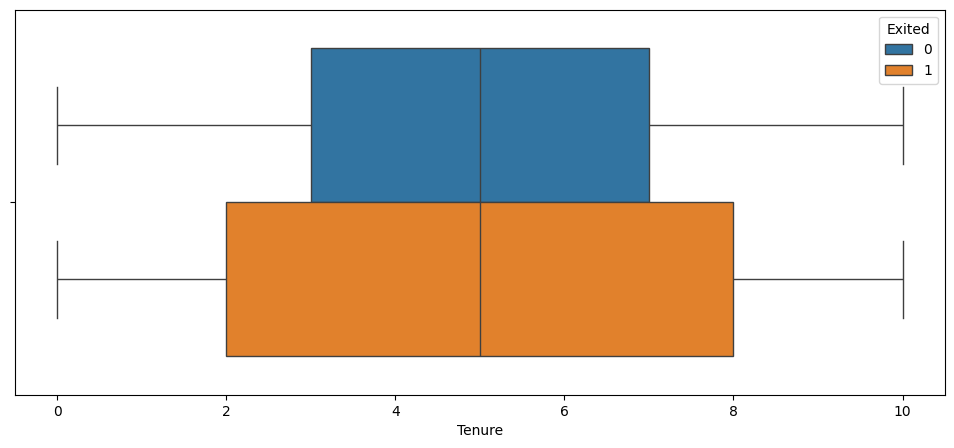

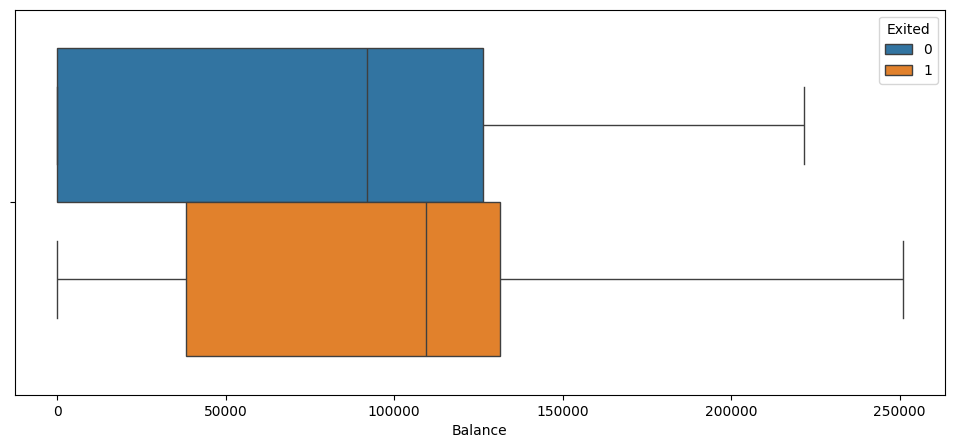

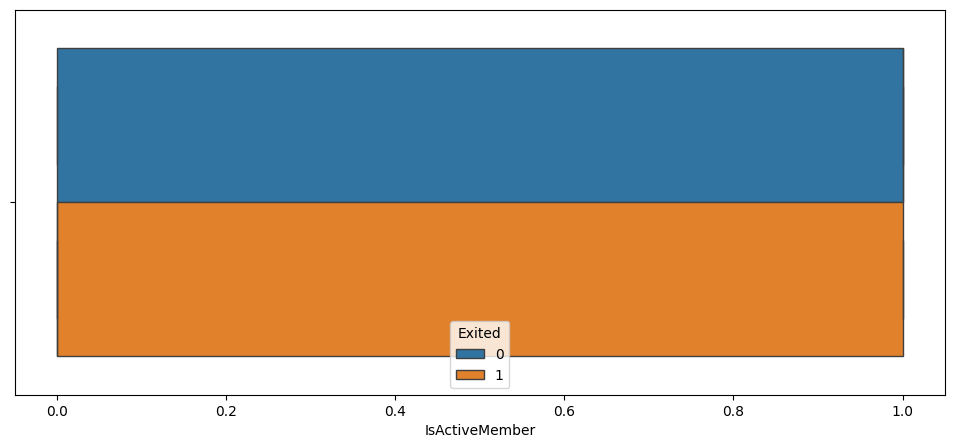

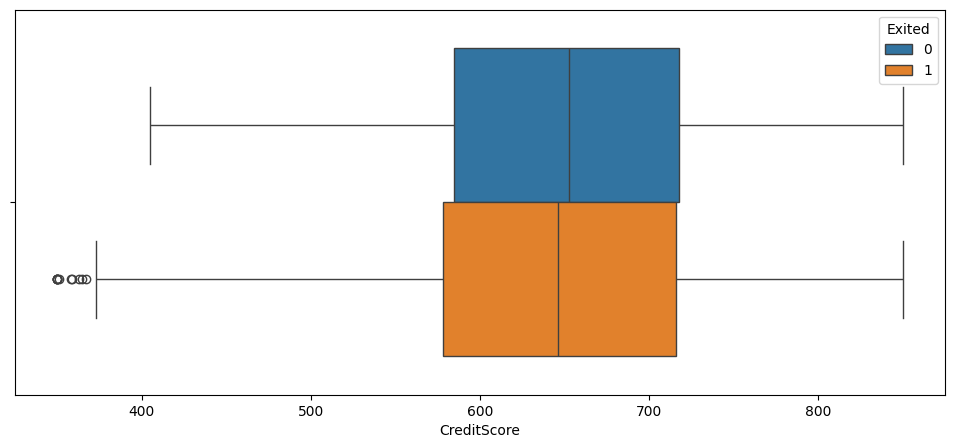

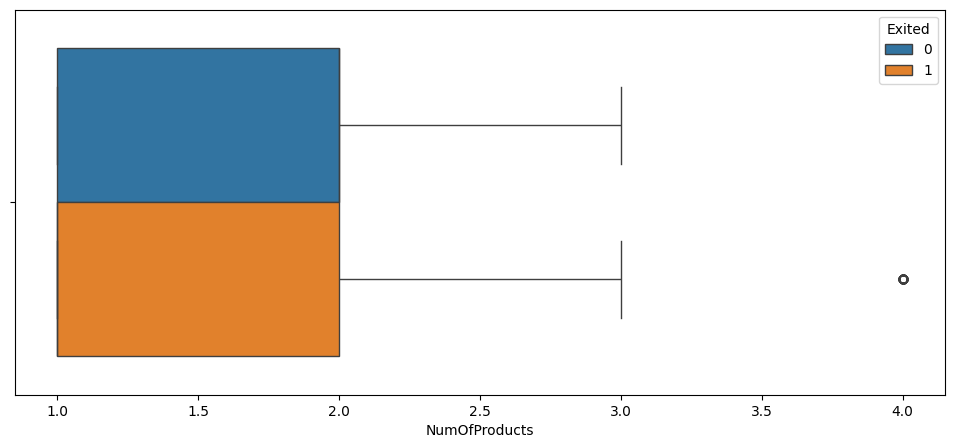

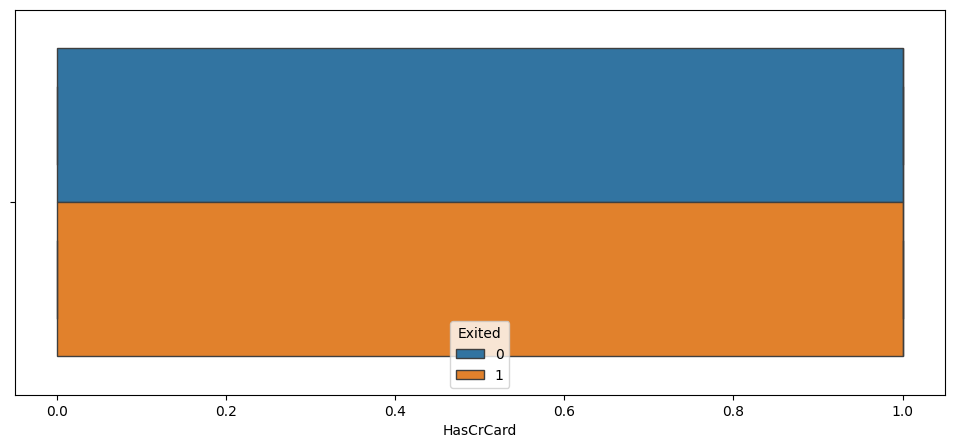

Exited         0         1
Tenure                    
0       0.769976  0.230024
1       0.775845  0.224155
2       0.808206  0.191794
3       0.788900  0.211100
4       0.794742  0.205258
5       0.793478  0.206522
6       0.797311  0.202689
7       0.827821  0.172179
8       0.807805  0.192195
9       0.783537  0.216463
10      0.793878  0.206122
Exited            0         1
Balance                      
0.00       0.861764  0.138236
3768.69         NaN  1.000000
12459.19        NaN  1.000000
14262.80   1.000000       NaN
16893.59   1.000000       NaN
...             ...       ...
216109.88       NaN  1.000000
221532.80  1.000000       NaN
222267.63       NaN  1.000000
238387.56       NaN  1.000000
250898.09       NaN  1.000000

[6382 rows x 2 columns]
Exited                 0         1
IsActiveMember                    
0               0.731491  0.268509
1               0.857309  0.142691
Exited              0         1
CreditScore                    
350               NaN  1.00000

In [ ]:
#Explanatory variables- analyzing the relationship between the hypothesized variables and the exited variable#
explan_vars = data[['Tenure', 'Balance', 'IsActiveMember', 'CreditScore', 'NumOfProducts', 'HasCrCard', 'Exited']]

for i, variable in enumerate(explan_vars.columns):
  if variable != 'Exited':
    #Create a plot figure#
    plt.figure(figsize=(12,5))
    #Build the boxplot of the variables#
    sns.boxplot(data = data, x= variable, hue= 'Exited')
    plt.show()


##Compute frequency distributions of grouped variables#

#Tenure#
tenure_by_churn = data.groupby('Tenure')['Exited'].value_counts(normalize=True).unstack()
print(tenure_by_churn)

#Balance#
balance_by_churn =data.groupby('Balance')['Exited'].value_counts(normalize=True).unstack()
print(balance_by_churn)

#IsActiveMember#
is_active_by_churn = data.groupby('IsActiveMember')['Exited'].value_counts(normalize=True).unstack()
print(is_active_by_churn)

#Credit Score#
creditscore_by_churn = data.groupby('CreditScore')['Exited'].value_counts(normalize=True).unstack()
print(creditscore_by_churn)

#HasCrCredit#
creditcard_by_churn = data.groupby('HasCrCard')['Exited'].value_counts(normalize=True).unstack()
print(creditcard_by_churn)

#NumOfProducts#
numofproducts_by_churn = data.groupby('NumOfProducts')['Exited'].value_counts(normalize=True).unstack()
print(numofproducts_by_churn)

#Estimated Salary#


###Other Variables to Analyze Further##

#Geography#
geography_by_churn = data.groupby('Geography')['Exited'].value_counts(normalize=True).unstack()
print(geography_by_churn)

#Gender#
gender_by_churn = data.groupby('Gender')['Exited'].value_counts(normalize=True).unstack()
print(gender_by_churn)


#Age#
age_by_churn = data.groupby('Age')['Exited'].value_counts(normalize=True).unstack()
print(age_by_churn)




Some Additional Findings:

1. Customers will no tenure are more likely to churn- ~23% churn for customers with 0 years of tenure vs. ~20% for other customers. This means that having no tenure with the bank increases the likelihood of churn by ~15%.
2. Inactive Customers have about a ~26.9% churn rate compared to ~14.3% for existing bank customers. This indicates that being an inactive bank customers increases the likelihood of churn by nearly double.
3. Having a credit card issued by the bank vs not having a credit card issued by the bank has no impact on churn.
4. Bank customers with very low credit scores appear to be highly likely to churn- however this relationship could be significantly more complex and non-linear
5. The impact of number of products a customer has and their churn rate appears to be non-linear in nature. For customers that have only one financial product the churn rate is ~27.7%, and for customers that have two financial products with the bank the churn rate substantially decreases to ~7.6%. However, once the numbers of financial products a customer has goes up to 3 or more, the churn rate is over ~80%.
6. Germany is the country with the highest churn rate based on geography, with an estimated churn rate of ~32.4%- substantially higher than other countries.
7. Gender appears to have an impact on churn as well. Females experienced a churn rate of ~25.1% compared to ~16.5% for males.


Newly Hypothesized Drivers:

*Macro Factors:
-Customer tenure
-Active vs Inactive bank status
-Number of financial products issued to customer
-Bank balance
-Credit Score

*Micro Factors (Customer-Specific Factors):

-Gender and Geography appear to be heavy contributors to churn
-Age probably has some bearing on churn rates as well


*To investigate further-
-Relationship between Estimated Salary, Geography, Gender, and Balance. Investigating for outliers



## Exploratory Data Analysis

### Univariate Analysis

Exited             0         1
Age_Bucket                    
0           0.923693  0.076307
1           0.906794  0.093206
2           0.850397  0.149603
3           0.714033  0.285967
4           0.540584  0.459416
Exited              0       1
Salary_Bucket                
0              0.8005  0.1995
1              0.8005  0.1995
2              0.7980  0.2020
3              0.7980  0.2020
4              0.7845  0.2155
Age_Bucket  Salary_Bucket
0           0                70916.874880
            1                79232.846341
            2                75012.930433
            3                72161.820039
            4                71429.262692
1           0                75856.468729
            1                74352.610570
            2                70897.270086
            3                75586.513196
            4                79266.620200
2           0                70312.953182
            1                75811.537643
            2                75254.765800
 

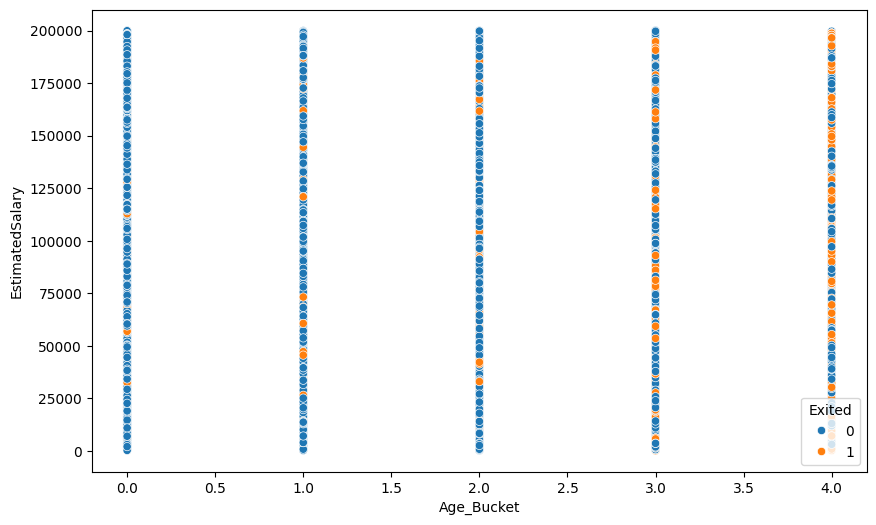

In [ ]:
#Create a copy of the original dataframe for EDA#
EDA_df = data.copy()

#Univariate Analysis#
#Bin age, estimated salary, and balance#
#EDA_df['Age'] = pd.qcut(EDA_df['Age'], q=10, labels=False)


#Create salary bins#
EDA_df['Salary_Bucket'] = pd.qcut(EDA_df['EstimatedSalary'], q=5, labels=False)
#labels=['Low', 'Medium', 'High', 'Very High', 'Extremely High'])

#Create age bucket/bins#
EDA_df['Age_Bucket'] = pd.qcut(EDA_df['Age'], q=5, labels=False)

#Analyze Churn rate by age bucket#
grouped_age_by_churn = EDA_df.groupby('Age_Bucket')['Exited'].value_counts(normalize=True).unstack()
print(grouped_age_by_churn)

#Analyze churn rate by Salary bucket#
grouped_salary_by_churn = EDA_df.groupby('Salary_Bucket')['Exited'].value_counts(normalize=True).unstack()
print(grouped_salary_by_churn)

#Analyze mean balance by age/salary buckets#
grouped_balance_by_age_salary = EDA_df.groupby(['Age_Bucket', 'Salary_Bucket'])['Balance'].mean()
print(grouped_balance_by_age_salary)


#Create a scatterplot visualizing the relationship between age bucket and salary#
plt.figure(figsize=(10,6))
sns.scatterplot(data=EDA_df, x='Age_Bucket', y='EstimatedSalary', hue='Exited')
plt.show()





### Bivariate Analysis

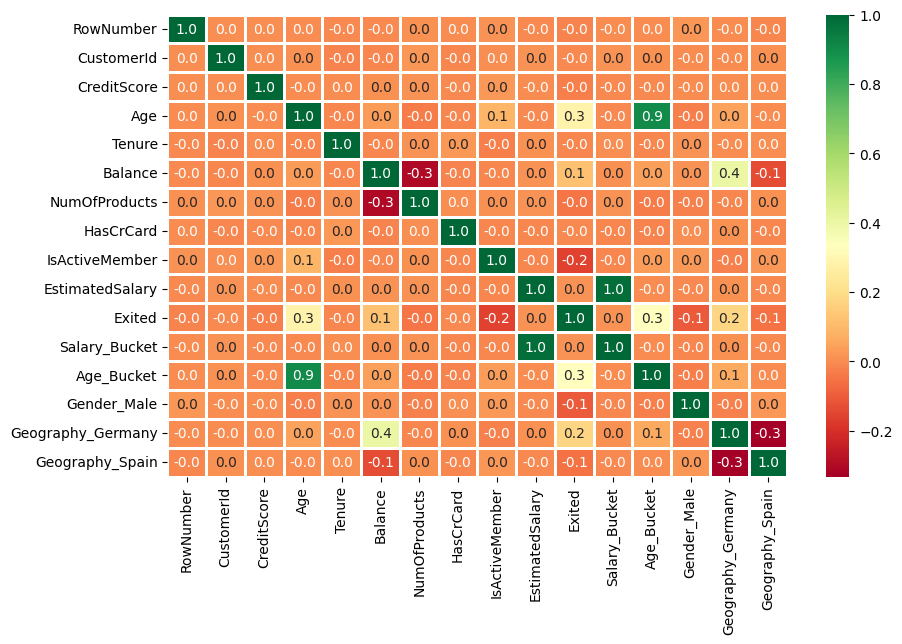

In [ ]:

#Select desired columns to analyze#
#EDA_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

selected_columns = EDA_df.select_dtypes(include=[np.number]).columns
categorical_columns = ['Gender', 'Geography']

#Encode categorical columns#
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(EDA_df[categorical_columns])

#Combine all columns into the dataframe#
combined_df = pd.concat([EDA_df[selected_columns], pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))], axis=1)


#Build Correlation Matrix#
plt.figure(figsize=(10,6));
sns.heatmap(combined_df.corr(), annot=True, cmap='RdYlGn', fmt='.1f', linewidths=1);
plt.show();


Based on the correlation heatmap and the scatterplot of age buckets above, the risk of churning is higher for older individuals compared to younger ones.

The country with the highest churn rate is Germany.

Being an active member of the bank tends to reduce the risk of churning.

Males are ~40% less likely than females to churn.

## Data Preprocessing

In [ ]:
#Remove Columns that are not needed#
#data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)#

print(data.info())

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
Index(['Surname', 'Geography', 'Gender'], dtype='object')


### Dummy Variable Creation

In [ ]:
#Create one-hot encoded variables for Geography and Gender#
encoder = pd.get_dummies(data[['Geography', 'Gender']], drop_first=True, dtype=int)
#Combine the two dataframes together#
encoded_df = pd.concat([data, encoder], axis=1)
#Drop the original columns#
encoded_df.drop(['Geography', 'Gender'], axis=1, inplace=True)

print(encoded_df)

      RowNumber  CustomerId    Surname  CreditScore  Age  Tenure    Balance  \
0             1    15634602   Hargrave          619   42       2       0.00   
1             2    15647311       Hill          608   41       1   83807.86   
2             3    15619304       Onio          502   42       8  159660.80   
3             4    15701354       Boni          699   39       1       0.00   
4             5    15737888   Mitchell          850   43       2  125510.82   
...         ...         ...        ...          ...  ...     ...        ...   
9995       9996    15606229   Obijiaku          771   39       5       0.00   
9996       9997    15569892  Johnstone          516   35      10   57369.61   
9997       9998    15584532        Liu          709   36       7       0.00   
9998       9999    15682355  Sabbatini          772   42       3   75075.31   
9999      10000    15628319     Walker          792   28       4  130142.79   

      NumOfProducts  HasCrCard  IsActiveMember  Est

### Train-validation-test Split

In [ ]:
#Isolate Features and Dependent Variables#
features = encoded_df.drop('Exited', axis=1)
target = encoded_df['Exited']

#Create initial train test split#
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#Create additional train test split to create validation set#
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

#Double Check The number of rows#
print("X Train:", X_train.shape[0])
print("X Validation:", X_val.shape[0])
print("X Test:", X_test.shape[0])

##Double Check Class Representativeness#
print("Y Train:", y_train.value_counts(normalize=True))
print("Y Validation:", y_val.value_counts(normalize=True))
print("Y Test:", y_test.value_counts(normalize=True))


X Train: 6400
X Validation: 1600
X Test: 2000
Y Train: Exited
0    0.794219
1    0.205781
Name: proportion, dtype: float64
Y Validation: Exited
0    0.795625
1    0.204375
Name: proportion, dtype: float64
Y Test: Exited
0    0.8035
1    0.1965
Name: proportion, dtype: float64


### Data Normalization

In [ ]:
##FIT THE SCALER ONLY ON THE TRAINING DATA TO AVOID DATA LEAKAGE!#


#Drop columns#

X_train = X_train.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
X_val = X_val.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
X_test = X_test.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

print(X_train.info())


#Instantiate standard scaler#
scaler_obj = StandardScaler()
#Fit and transform on the training set#
scaled_training_data = scaler_obj.fit_transform(X_train)

"""Validate transformations were made to the training dataset"""
# Check if mean is close to 0
assert np.allclose(scaled_training_data.mean(axis=0), 0, atol=1e-7)
# Check if standard deviation is close to 1
assert np.allclose(scaled_training_data.std(axis=0), 1, atol=1e-7)

#Trandform the validation set#
scaled_validation_data = scaler_obj.transform(X_val)

# Check if mean is close to 0
assert np.allclose(scaled_validation_data.mean(axis=0), 0, atol=1e-1)
# Check if standard deviation is close to 1
assert np.allclose(scaled_validation_data.std(axis=0), 1, atol=1e-1)

"""Validate transformations were made to the validation dataset"""
print(scaled_validation_data.mean(axis=0))
print(scaled_validation_data.std(axis=0))


#Transform the test set#

scaled_test_data = scaler_obj.transform(X_test)


# Check if mean is close to 0
assert np.allclose(scaled_validation_data.mean(axis=0), 0, atol=1e-1)
# Check if standard deviation is close to 1
assert np.allclose(scaled_validation_data.std(axis=0), 1, atol=1e-1)

#print(scaled_test_data.mean(axis=0))

#print(scaled_test_data.std(axis=0) )


"""Final Validation"""
print(scaled_training_data)
print(scaled_validation_data)
print(scaled_test_data)

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, 2579 to 6090
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6400 non-null   int64  
 1   Age                6400 non-null   int64  
 2   Tenure             6400 non-null   int64  
 3   Balance            6400 non-null   float64
 4   NumOfProducts      6400 non-null   int64  
 5   HasCrCard          6400 non-null   int64  
 6   IsActiveMember     6400 non-null   int64  
 7   EstimatedSalary    6400 non-null   float64
 8   Geography_Germany  6400 non-null   int64  
 9   Geography_Spain    6400 non-null   int64  
 10  Gender_Male        6400 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 600.0 KB
None
[ 0.01048521 -0.01797657  0.0376612  -0.01129696 -0.02179238  0.01093713
 -0.03189121  0.01160747 -0.00755736  0.04903473  0.01819379]
[1.0017186  1.0127744  1.00351326 0.99373465 0.99033326 0.99508346
 1.0005084  

## Model Building

In [ ]:
##Before building our models we will define some functions to plot the outputs##

def plot(history, name):
  #History- Object that stores details regarding the model performance
  #name- Determines which loss function to use#
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.plot(history.history[name], label='Training Loss')
  ax.plot(history.history['val_' + name] )
  plt.xlabel('Epochs')
  plt.ylabel(name.capitalize())
  plt.title( name + ' vs. Epochs')

  fig.legend({'Train', 'Validation'}, loc='outside right upper')
  plt.legend()
  plt.show()



##Next define the columns that will be included in our output##
results_df = pd.DataFrame(columns=['# of Hidden Layers', '# neurons- Hidden Layer', 'activation function- hidden layer', '# of epochs', 'batch_size', 'Optimizer', 'Learning Rate', 'Momentum Rate', 'Dropout', 'Train Loss', 'Validation Loss', 'Train Recall', 'Validation Recall', 'Time to Train (secs)'])


print(results_df)


Empty DataFrame
Columns: [# of Hidden Layers, # neurons- Hidden Layer, activation function- hidden layer, # of epochs, batch_size, Optimizer, Learning Rate, Momentum Rate, Dropout, Train Loss, Validation Loss, Train Recall, Validation Recall, Time to Train (secs)]
Index: []


### Model Evaluation Criterion

Write down the logic for choosing the metric that would be the best metric for this business scenario.

-Goal is to optimize accuracy of predictions, considering the cost of incorrect predictions in either direction

-What happens if we predict too many churners? - If we predict too many churners we will waste marketing resources and promotional offers on customers that weren't going to churn which can get quite expensive.

-What happens if we don't predict enough churners?- If we don't predict enough churners, we will save on marketing resources and promotional offers on customers, but we will lose a larger proportion of customers, which is probably more expensive in the long-run.

-What is the balance between the two? -
Most likely the cost of losing a customer to churn is much greater than the marketing resources that will expended to prevent it. However, this is likely to be situational- losing a customer that is highly loyal will undoubtedly cost more than losing a customer that is more 'marginal'

We therefore will consider recall our primary metric, with F-1 score followed closely behind, we want strong recall and a strong balance if we can get it.



<Sequential name=sequential, built=False>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 42259.3945 - recall: 0.2092 - val_loss: 13857425.0000 - val_recall: 0.7956
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - loss: 13610646.0000 - recall: 0.7942 - val_loss: 9907133.0000 - val_recall: 0.7956
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9715693.0000 - recall: 0.7942 - val_loss: 5956842.0000 - val_recall: 0.7956
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5820741.0000 - recall: 0.7942 - val_loss: 2006551.3750 - val_recall: 0.7956
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1925788.5000 - recall: 0.7942 - val_loss: 6285528.5000 - val_recall: 0.2044
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6310812.0000 - recall: 0.2058 - val_loss: 11926259.0000 - val_recall: 0.7956
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 11653937.0000 - recall: 0.7942 - val_loss: 7975969.5000 - val_recall: 0.7956
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 7758983.000

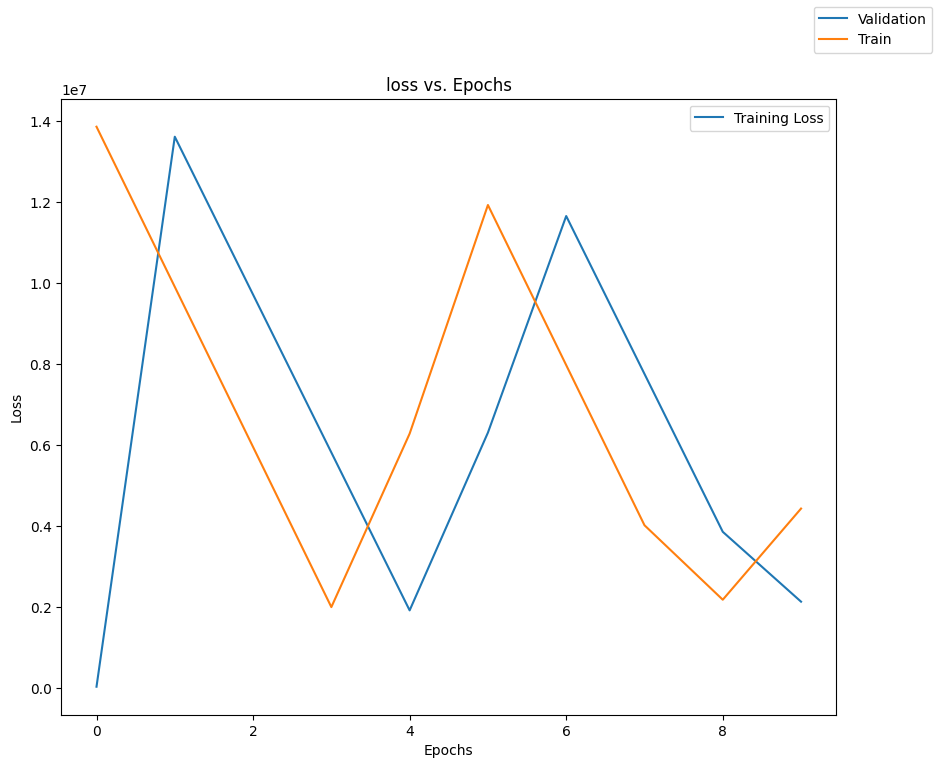

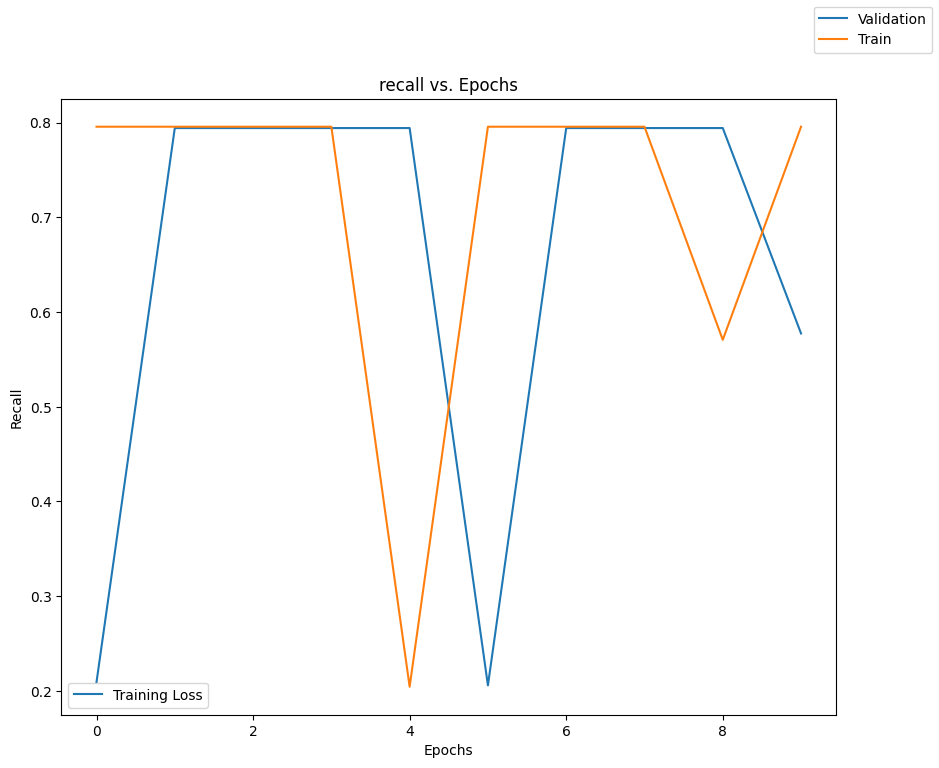

Index(['# of Hidden Layers', '# neurons- Hidden Layer',
       'activation function- hidden layer', '# of epochs', 'batch_size',
       'Optimizer', 'Learning Rate', 'Momentum Rate', 'Dropout', 'Train Loss',
       'Validation Loss', 'Train Recall', 'Validation Recall',
       'Time to Train (secs)'],
      dtype='object')
   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   

  activation function- hidden layer  # of epochs  batch_size Optimizer  \
0                                 -           10        6400       SGD   

  Learning Rate Momentum Rate Dropout  Train Loss  Validation Loss  \
0         0.001             -       -   2140289.5        4437412.0   

   Train Recall  Validation Recall  Time to Train (secs)  
0      0.577344           0.795625              3.733916  


In [ ]:
#Creating a baseline neural network model#
num_classes = 2 #2 classes to predict- exited vs not exited#

#Clear previous session/model#
K.clear_session()

#Set the seed#
tf.keras.utils.set_random_seed(418)

#Initialize the model#
model_0 = tf.keras.Sequential()

print(model_0)

#Add output layer#
model_0.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid', input_dim = X_train.shape[1]))
#Output model summary#
model_0.summary()

#Compile the model#
model_0.compile(optimizer='sgd', loss='binary_crossentropy', metrics = ["recall"] )
#Specify batch sizes and epochs#
batch_size = X_train.shape[0]
epochs = 10


##One hot encode target variables#
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

#Before beginning model training we are going to set the start time#
start = time.time()

#Fit the model#
history = model_0.fit(X_train, y_train_encoded, batch_size=batch_size, epochs = epochs, validation_data= (X_val, y_val_encoded))

end = time.time()

print(end - start)
print(history)


#Plot graph#
plot(history, 'loss')

plot(history, 'recall')

#plot(history, 'f1-score')#


##Retrieve columns from the results dataframe#
print(results_df.columns)

#Add results to the results dataframe#
results_df.loc[0] = [0, '-', '-', epochs, batch_size, 'SGD', '0.001', '-', '-', history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)



We have built a simple baseline neural network for model comparison evaluation

*   Since this is a binary classification problem we designed the neural network to take in 2 input classes and 2 output classes with an activation function of sigmoid to transform the output layer to probabilities

*   We have no hidden layers in our first model, and the final model has 24 trainable parameters

*   Validation Recall far exceeds training accuracy indicating the model is underfitting - as would be expected for a simple baseline model.


*   Challenges observed-
1. Instability and substantial oscillations in our converge path and probably gradients
2. Loss function values are far too high

Changes to consider making next-

1. Change the batch size or # of epochs- to allow more updates to weights and biases
2. Incorporate SGD w/ Momentum
3. Incorporate Batch normalization
4. Improve the optimization algorithm used to compute the gradients- Such as using RMSProp or Adam.


### Neural Network with SGD Optimizer

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6392589.0000 - recall: 0.6614 - val_loss: 7315134.0000 - val_recall: 0.3963
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5927038.5000 - recall: 0.6659 - val_loss: 8181456.0000 - val_recall: 0.7956
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6208385.0000 - recall: 0.6709 - val_loss: 3768428.7500 - val_recall: 0.6187
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6138036.0000 - recall: 0.6632 - val_loss: 11053463.0000 - val_recall: 0.7956
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6361365.0000 - recall: 0.6629 - val_loss: 5425640.5000 - val_recall: 0.7956
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6035913.0000 - recall: 0.6713 - val_loss: 11053220.0000 - val_recall: 0.7956
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6203552.5000 - recall: 0.6734 - val_loss: 8972374.0000 - val_recall: 0.7956
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

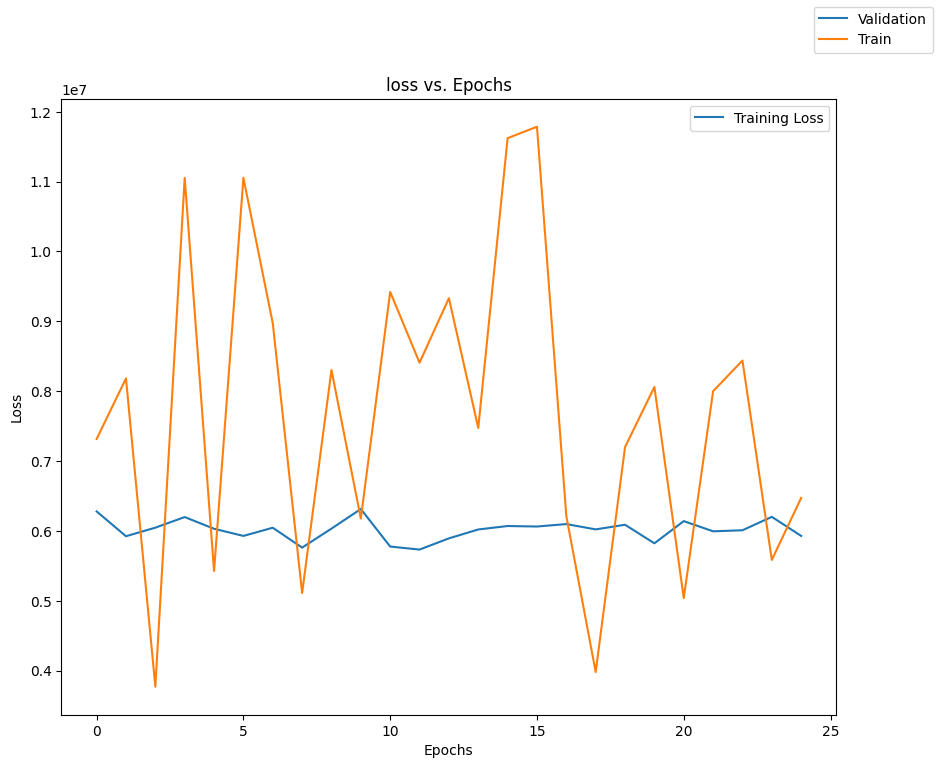

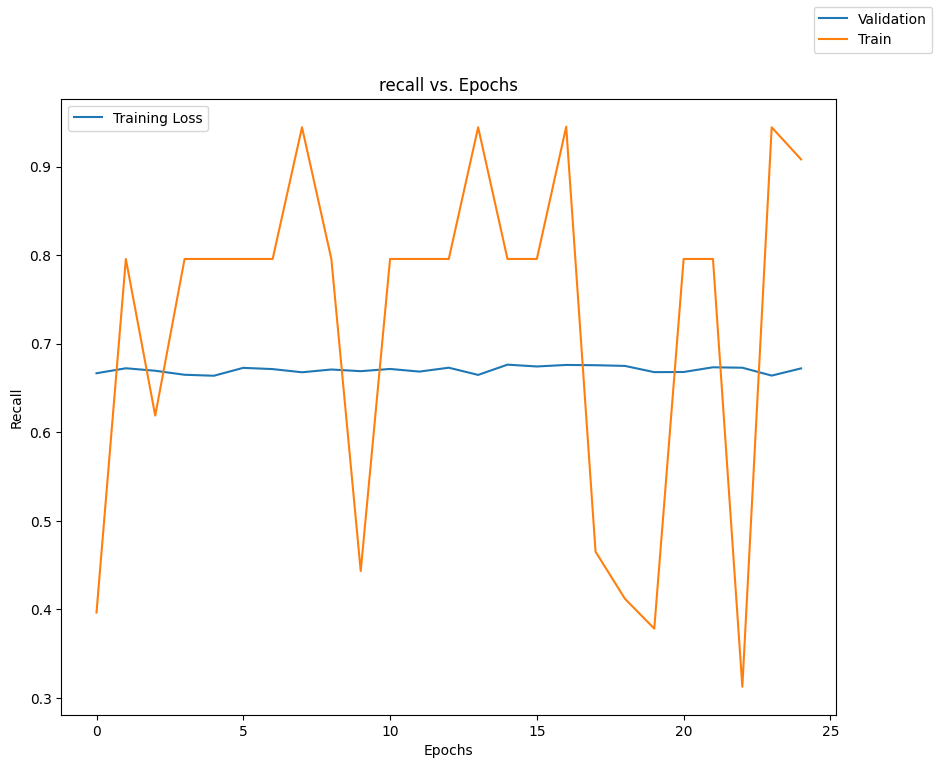

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   

  activation function- hidden layer  # of epochs  batch_size Optimizer  \
0                                 -           10        6400       SGD   
1                                 -           25          32       SGD   

  Learning Rate Momentum Rate Dropout  Train Loss  Validation Loss  \
0         0.001             -       -   2140289.5        4437412.0   
1         0.001             -       -   5927361.5        6471328.0   

   Train Recall  Validation Recall  Time to Train (secs)  
0      0.577344           0.795625              3.733916  
1      0.672031           0.908125             15.386197  


In [ ]:
#Set the seed for our random generation#
tf.keras.utils.set_random_seed(418)

#Clear keras backend/previous session#
K.clear_session()

#Initialize the neural network model#
model_1 = tf.keras.Sequential()   #This also creates the input layer so we don't have to create this later#

#Convert target variables as required prior to building the neural network#
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Build any hidden layers#
#For this neural network we are not going to build any hidden layer#

#Build output layer#
model_1.add(tf.keras.layers.Dense(num_classes, activation= 'sigmoid', input_dim = X_train.shape[1] ))
model_1.summary()

#Compile the model using Stochastic Gradient Descent and the binary-cross entropy loss function#
model_1.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['recall'])
#Specify the number of epochs and the batch size#
epochs = 25
batch_size = 32

#Add the start time before beginning model training#
start_time = time.time()

#Train the model using X train and the encoded variables, and evaluate it on the evaluation set#
history = model_1.fit(
    X_train, y_train_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)

#Call the plot function to view our results#
plot(history, 'loss')
plot(history, 'recall')


#Add the results to the dataframe#
results_df.loc[1] = [0, '-', '-', epochs, batch_size, 'SGD', '0.001', '-', '-', history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], time.time() - start_time]

print(results_df)

Incorporating smaller batch sizes and more epochs helped improved training performance but had no impact on validation accuracy.

*   Variability in the loss functions appears to be dropping as we increase the number of epochs and reduce the batch size to 32.

*   Training and Validation loss appear to be converging closer.

*   Gap betwen validation and training scores for recall still exists, indicating the model is still underfitting.

*   Jumpy rather than smooth pathway towards its eventual stopping point


*   Adding more epochs and more weight updates using a smaller batch size appeared to substantially boost validation performance.


## Model Performance Improvement

### Neural Network with Adam Optimizer

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5540 - recall: 0.7104 - val_loss: 0.5222 - val_recall: 0.7956
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5098 - recall: 0.7925 - val_loss: 0.5082 - val_recall: 0.7956
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5043 - recall: 0.7925 - val_loss: 0.5091 - val_recall: 0.7956
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5038 - recall: 0.7925 - val_loss: 0.5081 - val_recall: 0.7956
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5037 - recall: 0.7925 - val_loss: 0.5081 - val_recall: 0.7956
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5043 - recall: 0.7925 - val_loss: 0.5106 - val_recall: 0.7956
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5044 - recall: 0.7925 - val_loss: 0.5082 - val_recall: 0.7956
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5036 - recall: 0.7925 - val_loss: 0.5076 - val_recall: 0.7956
Epoch 9/

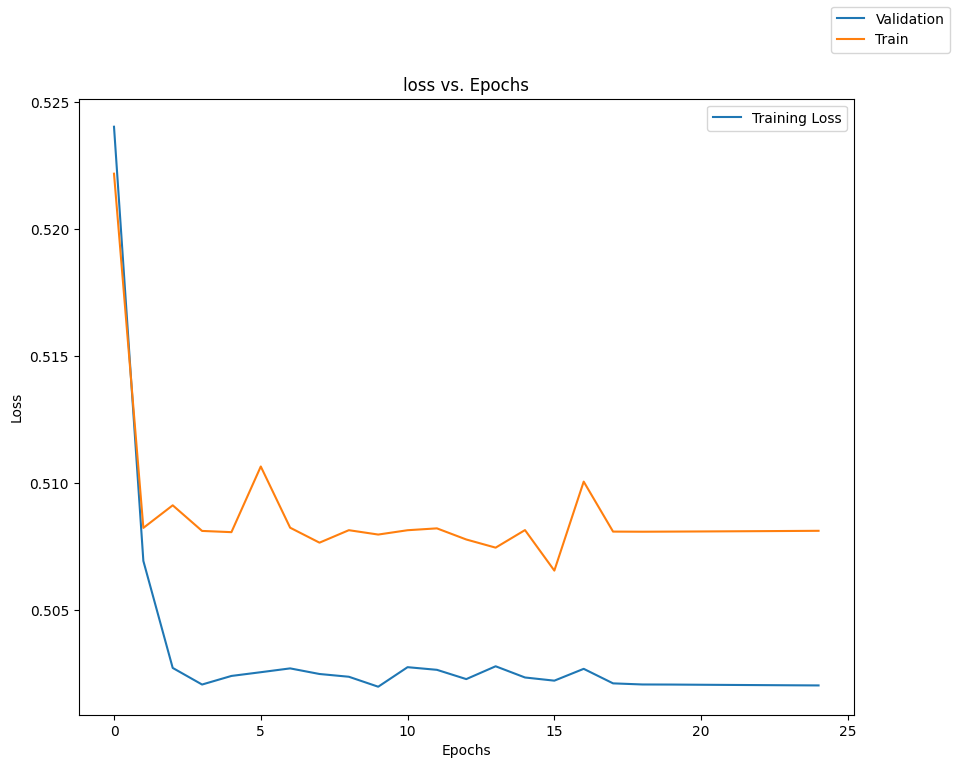

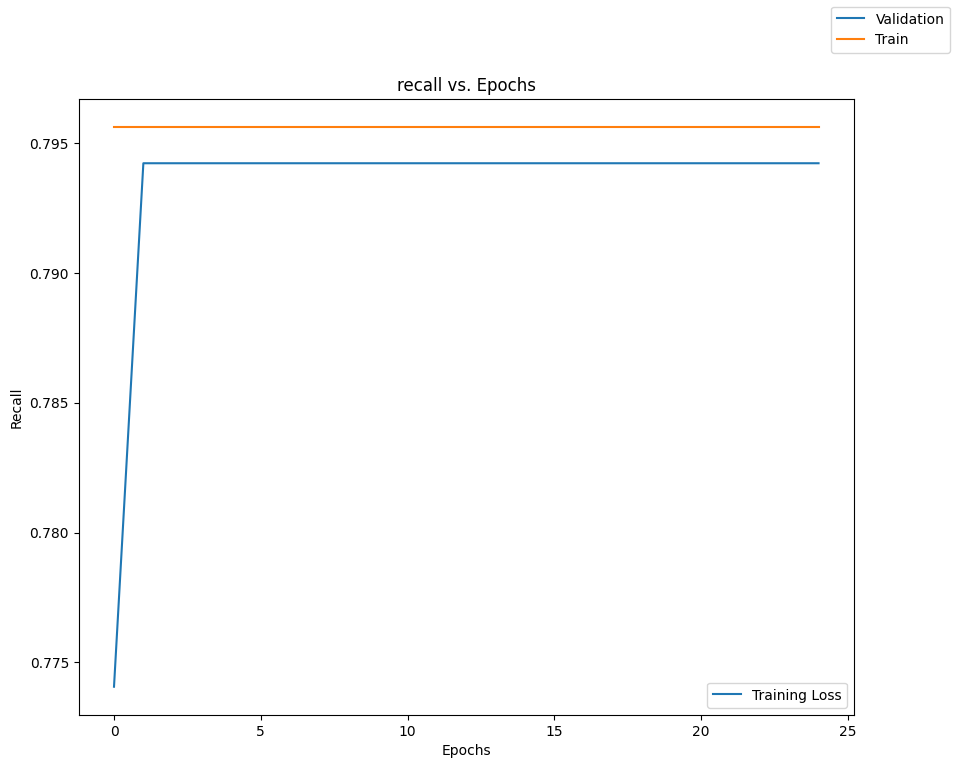

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   

  activation function- hidden layer  # of epochs  batch_size Optimizer  \
0                                 -           10        6400       SGD   
1                                 -           25          32       SGD   
2                         relu/tanh           25          32      Adam   

  Learning Rate Momentum Rate Dropout    Train Loss  Validation Loss  \
0         0.001             -       -  2.140290e+06     4.437412e+06   
1         0.001             -       -  5.927362e+06     6.471328e+06   
2         0.001             -       -  5.020176e-01     5.081116e-01   

   Train Recall  Validation Recall  Time to Train (secs)  
0      0.577344           0.795625              3.733916  
1      0.672031           0.908125             15.386197  
2      0.794219           0.795625      

In [ ]:
#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Clear the backend/session history#
K.clear_session()

#Initialize the model#
model_2 = tf.keras.Sequential()

#Convert target variables#
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Add hidden layer as applicable#
#Add a hidden layer with 128 neurons and sigmoid as the activation function#
model_2.add(tf.keras.layers.Dense(128, activation = 'relu', input_dim = X_train.shape[1] ))

#Add a second hidden layer with activation 'tanh' to introduce non-linearity#
model_2.add(tf.keras.layers.Dense(128, activation = 'tanh'))

#Add output layer  as applicable#
model_2.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid'))
model_2.summary()

#Compile the model using the Adam Optimizer#
model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['recall'])

#Specify the batch size and epochs#
batch_size = 32
epochs = 25

#Add the start time#
start = time.time()

#Fit the model#
history = model_2.fit(
    X_train, y_train_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)

#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')

#Add the results to the dataframe#
results_df.loc[2] = [2, 128, 'relu/tanh', epochs, batch_size, 'Adam', '0.001', '-', '-', history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)




*   We keep batch size at 32, and epochs at 25 for this run.
*   We add 2 hidden layers with 128 neurons with 'relu' and 'tanh' for our activation functions respectively.

*   Applying Adam optimizer and adding 2 layers with 128 neurons appeared to
improve training recall and remove the gap between training and validation performance

*   However, we can observe that the validation recall has dropped substantially.

*   Training and Validation losses are substantially reduced through applying Adam.

We are going to keep the neural network structure the same in the next model
-One input layer
-Two hidden layers with 128 neurons, using relu and tanh respectively as activation functions
-One output layer using sigmoid for binary classification
-batch size = 32
-epochs = 25





Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5495 - recall: 0.8157 - val_loss: 0.5094 - val_recall: 0.7950
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5077 - recall: 0.7923 - val_loss: 0.5045 - val_recall: 0.7950
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5048 - recall: 0.7924 - val_loss: 0.5031 - val_recall: 0.7950
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5036 - recall: 0.7925 - val_loss: 0.5035 - val_recall: 0.7956
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5030 - recall: 0.7925 - val_loss: 0.5029 - val_recall: 0.7956
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5028 - recall: 0.7925 - val_loss: 0.5029 - val_recall: 0.7956
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5028 - recall: 0.7925 - val_loss: 0.5033 - val_recall: 0.7956
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5023 - recall: 0.7925 - val_loss: 0.5032 - val_recall: 0.7956
Epoch 9/

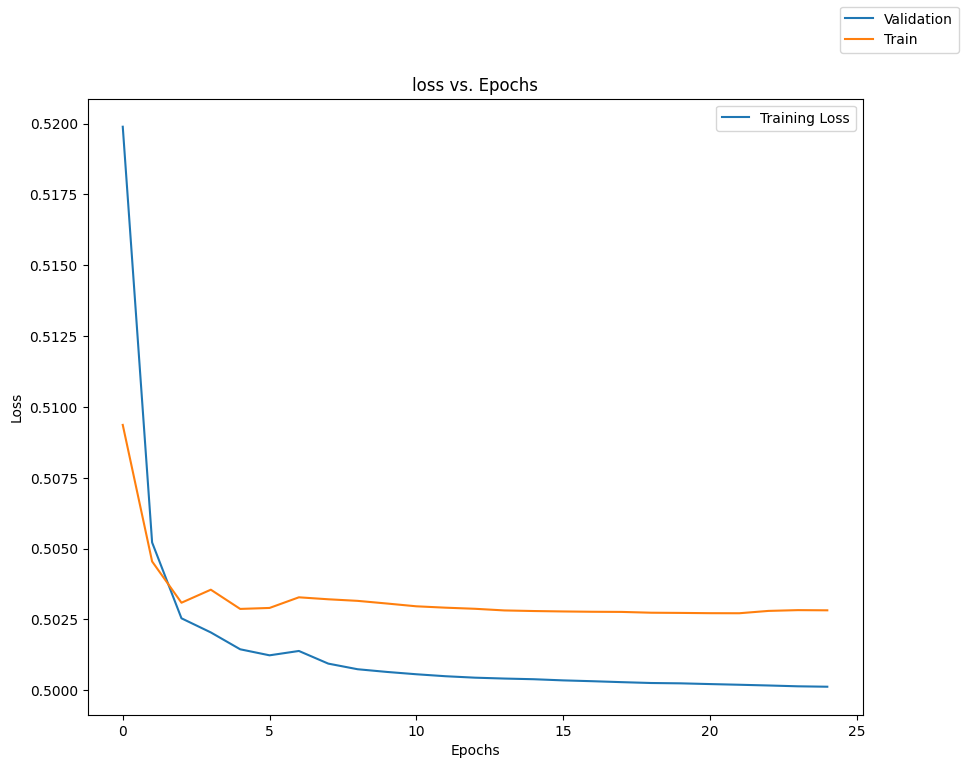

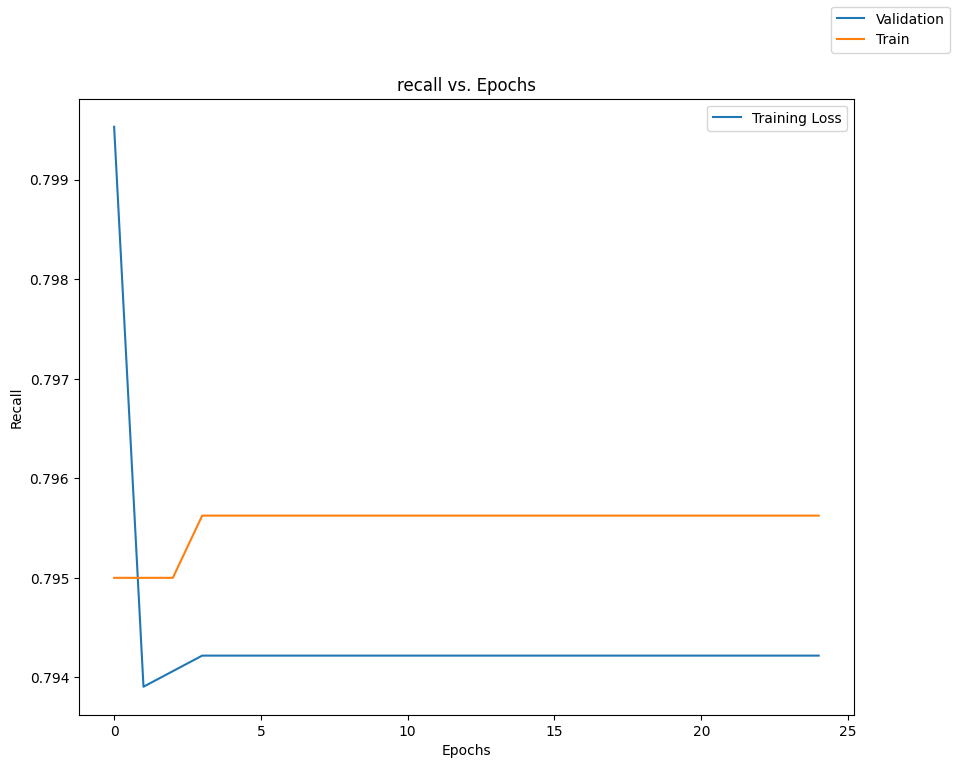

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   

               Optimizer Learning Rate Momentum Rate Dropout    Train Loss  \
0                    SGD         0.001             -       -  2.140290e+06   
1                    SGD         0.001             -       -  5.927362e+06   
2                   Adam         0.001             -       -  5.020176e-01   
3  SGD w/ momentum = 0.1         0.001           0.1       -  5.001235e-01   

   Validation Loss  Train Recall  Validati

In [ ]:
##Next we might be inclined to try SGD w/ Momentum since the default settings appeared to result in local maxima##

#Clear the backend/session history#
K.clear_session()

#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Initialize the model#
model_3 = tf.keras.Sequential()

#Convert target variables#
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Add hidden layer as applicable#
#Add a hidden layer with 128 neurons and tanh as the activation function#
model_3.add(tf.keras.layers.Dense(128, activation = 'tanh', input_dim = X_train.shape[1] ))

#Add a second hidden layer with activation 'tanh' to introduce non-linearity#
model_3.add(tf.keras.layers.Dense(128, activation = 'tanh', input_dim= X_train.shape[1]))

#Add output layer  as applicable#
model_3.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid'))
model_3.summary()

##Start with a modest amount of momentum first#
optimizer = tf.keras.optimizers.SGD(momentum = 0.1)

#Compile the model using the Adam Optimizer#
model_3.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['recall'])

#Specify the batch size and epochs#
batch_size = 32
epochs = 25

#Add the start time#
start = time.time()

#Fit the model#
history = model_3.fit(
    X_train, y_train_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)

#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')

#Add the results to the dataframe#
results_df.loc[3] = [2, 128, 'tanh/tanh', epochs, batch_size, 'SGD w/ momentum = 0.1', '0.001', '0.1', '-', history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)



### Neural Network with Adam Optimizer and Dropout

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,306 (71.51 KB)

 Trainable params: 18,306 (71.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5750 - recall: 0.7227 - val_loss: 0.5158 - val_recall: 0.7950
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5235 - recall: 0.7883 - val_loss: 0.5131 - val_recall: 0.7956
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5196 - recall: 0.7904 - val_loss: 0.5118 - val_recall: 0.7956
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5190 - recall: 0.7922 - val_loss: 0.5101 - val_recall: 0.7956
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5137 - recall: 0.7924 - val_loss: 0.5090 - val_recall: 0.7956
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5110 - recall: 0.7924 - val_loss: 0.5079 - val_recall: 0.7956
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5106 - recall: 0.7913 - val_loss: 0.5071 - val_recall: 0.7956
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5083 - recall: 0.7924 - val_loss: 0.5072 - val_recall: 0.7956
Epoch 9/

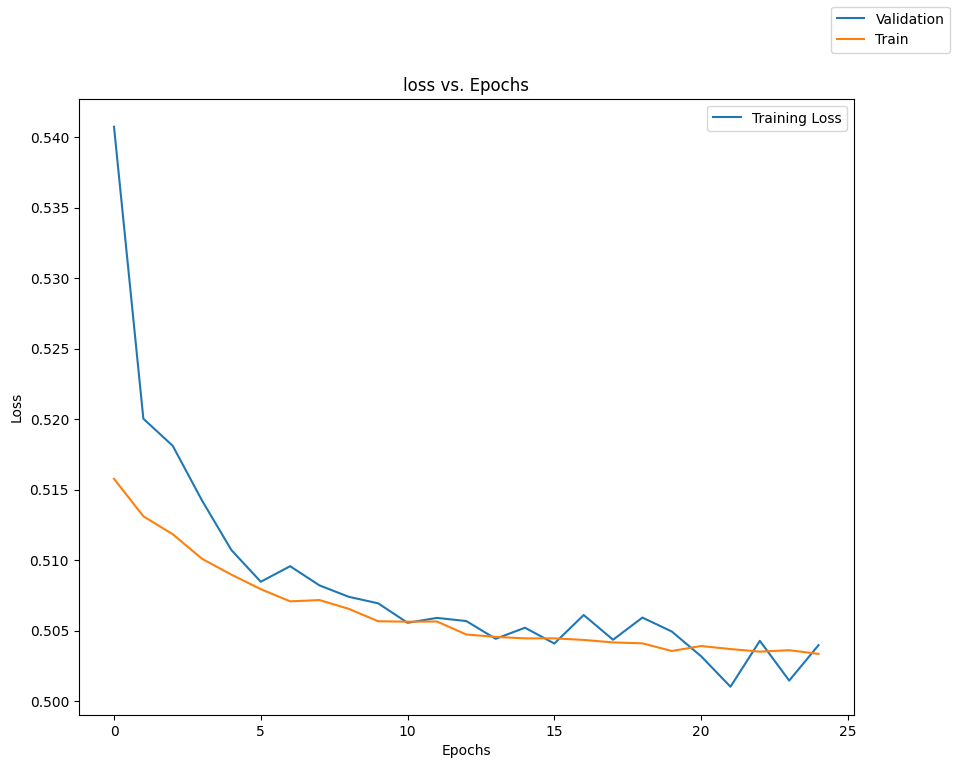

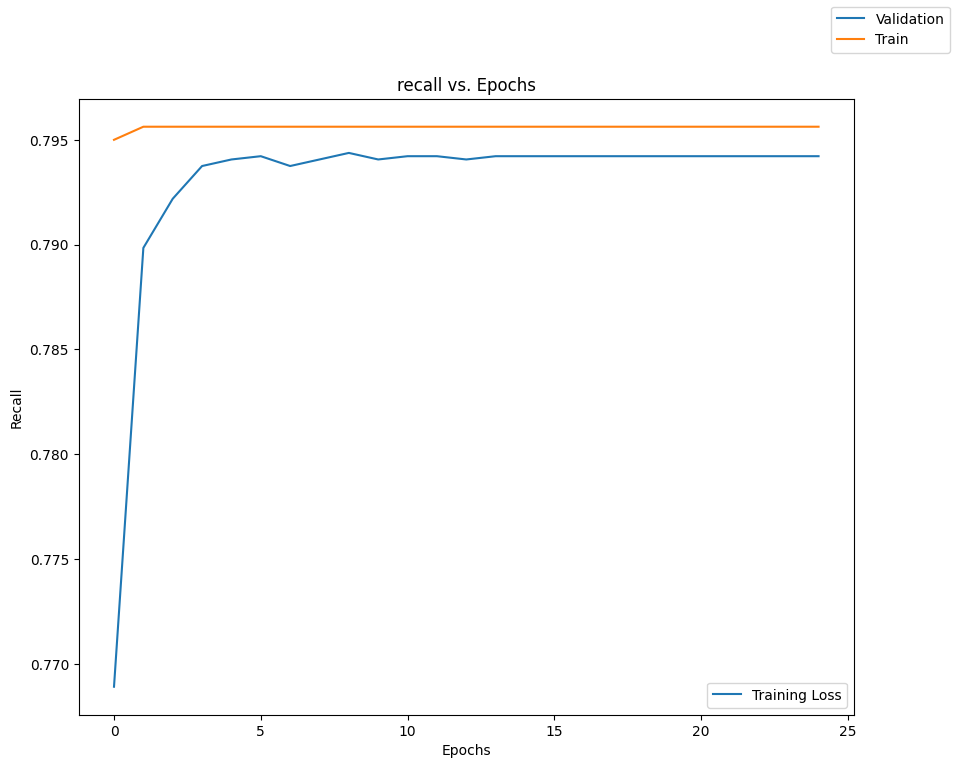

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   
4                   2                     128   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   
4                         tanh/tanh           25          32   

               Optimizer Learning Rate Momentum Rate Dropout    Train Loss  \
0                    SGD         0.001             -       -  2.140290e+06   
1                    SGD         0.001             -       -  5.927362e+06   
2                   Adam         0.001             -       -  5.020176e-01   
3  SGD w

In [ ]:

#Clear the backend/session history#
K.clear_session()

#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Convert target variables#
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

print(y_train_encoded)
print(y_val_encoded)

#Specify dropout rate#
dropout_rate = 0.3

#Initialize the model#
model_4 = tf.keras.Sequential()

#Add hidden layer as applicable#
#Add a hidden layer with 128 neurons and tanh as the activation function#
model_4.add(tf.keras.layers.Dense(128, activation = 'tanh', input_dim = X_train.shape[1] ))

#Create our dropout layer#
model_4.add(tf.keras.layers.Dropout(rate = dropout_rate))

#Add a second hidden layer with activation 'tanh' to introduce non-linearity#
model_4.add(tf.keras.layers.Dense(128, activation = 'tanh'))

#Add output layer  as applicable#
model_4.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid') )
model_4.summary()



#Compile the model using the Adam Optimizer#
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model_4.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['recall'])

#Specify the batch size and epochs#
batch_size = 32
epochs = 25

#Add the start time#
start = time.time()

#Fit the model#
history = model_4.fit(
    X_train, y_train_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)


#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')


#Add the results to the dataframe#
results_df.loc[4] = [2, 128, 'tanh/tanh', epochs, batch_size, 'Adam', learning_rate, '-', dropout_rate, history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)


From observing the performance above it is clear the model appears to be stuck at slightly less than 80% accuracy.
Dropout appeared to improve model performance, and smooth convergence but the class imbalance in our dataset appears to limit the score we can achieve on the original dataset.



*   Still under-fitting the model
*   Discrepancy between training and validation appears to be substantially removed with more hidden layers, improving the optimizer, and dropout.



*   One thing we haven't addressed yet is the class imbalance in the dataset, this may be the reason why our neural network appears to be stuck.


*   Highly imbalanced dataseta can lead to significantly more false positives - reducing the recall score



*   Next, we will address this by performing undersampling and/or oversampling and see how it impacts our model performance







### Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer

Oversampled X Train: 10166
Oversampled y Train: 10166
Epoch 1/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6952 - recall: 0.5456 - val_loss: 0.7263 - val_recall: 0.2094
Epoch 2/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6900 - recall: 0.5251 - val_loss: 0.6879 - val_recall: 0.4913
Epoch 3/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6832 - recall: 0.5530 - val_loss: 0.6855 - val_recall: 0.4619
Epoch 4/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6815 - recall: 0.5790 - val_loss: 0.6843 - val_recall: 0.4619
Epoch 5/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6809 - recall: 0.5785 - val_loss: 0.6838 - val_recall: 0.4619
Epoch 6/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6806 - recall: 0.5781 - val_loss: 0.6836 - val_recall: 0.4619
Epoch 7/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6804 - recall: 0.5781 - val_loss: 0.6835 - val_recall: 0.4619
Epoch 8/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6803 - recall: 0

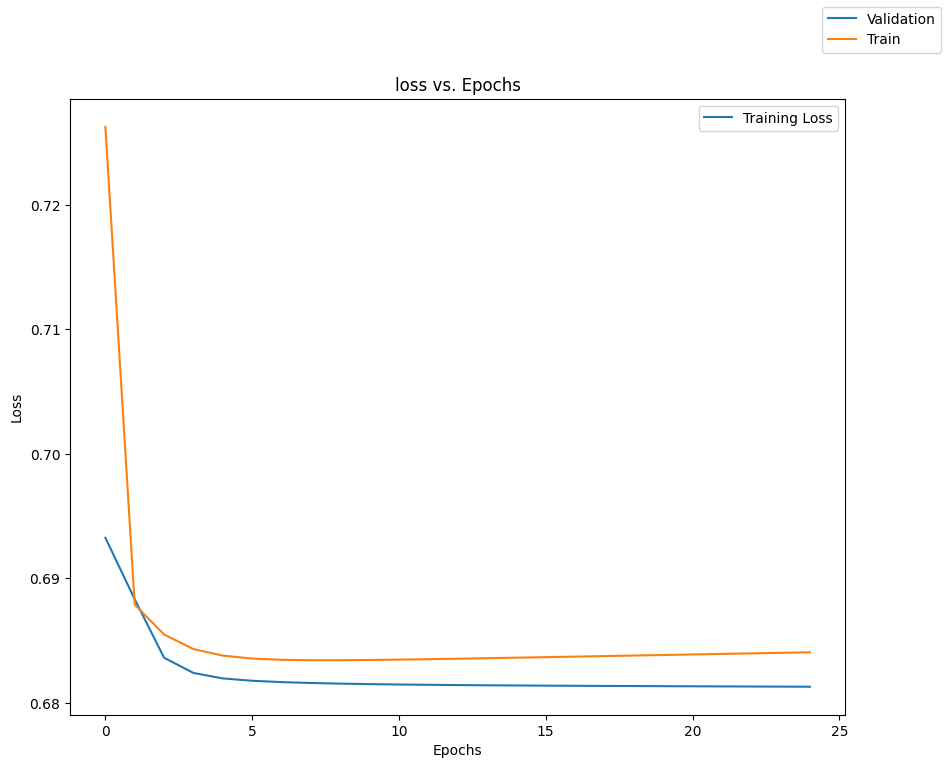

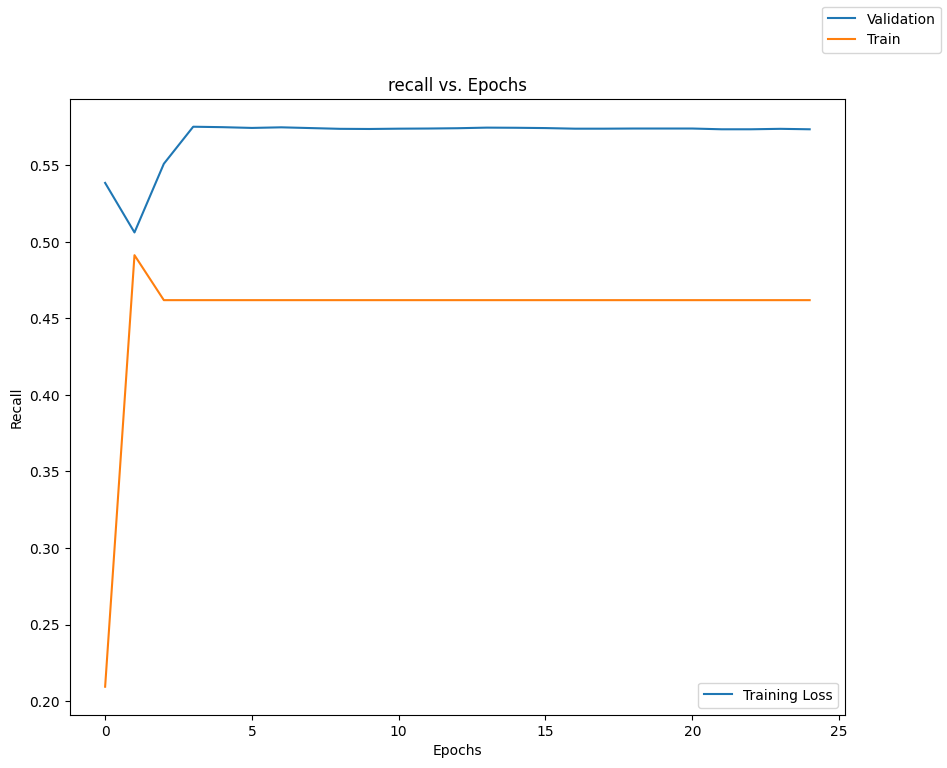

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   
4                   2                     128   
5                   2               [32, 128]   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   
4                         tanh/tanh           25          32   
5                         tanh/tanh           25          32   

               Optimizer Learning Rate Momentum Rate Dropout    Train Loss  \
0                    SGD         0.001             -       -  2.140290e+06   
1                    SGD         0.001             

In [ ]:

#Clear the backend/session history#
K.clear_session()

#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Apply Oversampling and SMOTE#
over_sampled_dataset = SMOTE(random_state = 418)

X_train_over, y_train_over = over_sampled_dataset.fit_resample(X_train, y_train)

print("Oversampled X Train:", X_train_over.shape[0])
print("Oversampled y Train:", y_train_over.shape[0])

#Initialize the model#
model_5 = tf.keras.Sequential()

#Convert target variables#
#Use the variables encoded from applying SMOTE above#

y_train_over_encoded = tf.keras.utils.to_categorical(y_train_over, num_classes = num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Add hidden layer as applicable#
model_5.add(tf.keras.layers.Dense(32, activation = 'tanh', input_dim = X_train_over.shape[1]))


#Add a hidden layer with 32 neurons and sigmoid as the activation function#
model_5.add(tf.keras.layers.Dense(128, activation = 'tanh') )


#Add output layer  as applicable#
model_5.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid') )

#Compile the model using the SGD optimizer#
optimizer = tf.keras.optimizers.SGD(momentum = 0.2)

model_5.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['recall'])#

#Specify the batch size and epochs#
batch_size = 32
epochs = 25

#Add the start time#
start = time.time()

#Fit the model#
history = model_5.fit(
    X_train_over, y_train_over_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)



#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')


#Add the results to the dataframe#
results_df.loc[5] = [2, [32,128], 'tanh/tanh', epochs, batch_size, 'SGD', '0.001', 0.2, '-', history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)

After applying oversampling our performance appears to have drastically changed.

-We may have too many epochs
-We may have an overly complex model
-Train performance > validation performance indicating a heightened risk of overfitting
-Using momentum appeared to have a very strong impact on optimization trajectory and led to a higher prescence of oscillations in the data

-We now want to make the model less complex

### Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer

Epoch 1/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.8005 - recall: 0.7772 - val_loss: 0.6427 - val_recall: 0.9062
Epoch 2/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8001 - recall: 0.7772 - val_loss: 0.6427 - val_recall: 0.9062
Epoch 3/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7997 - recall: 0.7772 - val_loss: 0.6428 - val_recall: 0.9062
Epoch 4/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7994 - recall: 0.7772 - val_loss: 0.6428 - val_recall: 0.9062
Epoch 5/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7990 - recall: 0.7772 - val_loss: 0.6428 - val_recall: 0.9062
Epoch 6/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7986 - recall: 0.7772 - val_loss: 0.6428 - val_recall: 0.9062
Epoch 7/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7982 - recall: 0.7772 - val_loss: 0.6428 - val_recall: 0.9062
Epoch 8/25
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7978 - recall: 0.7772 - val_loss: 0.6429 - val_recall: 0.9062
Epoch 9/

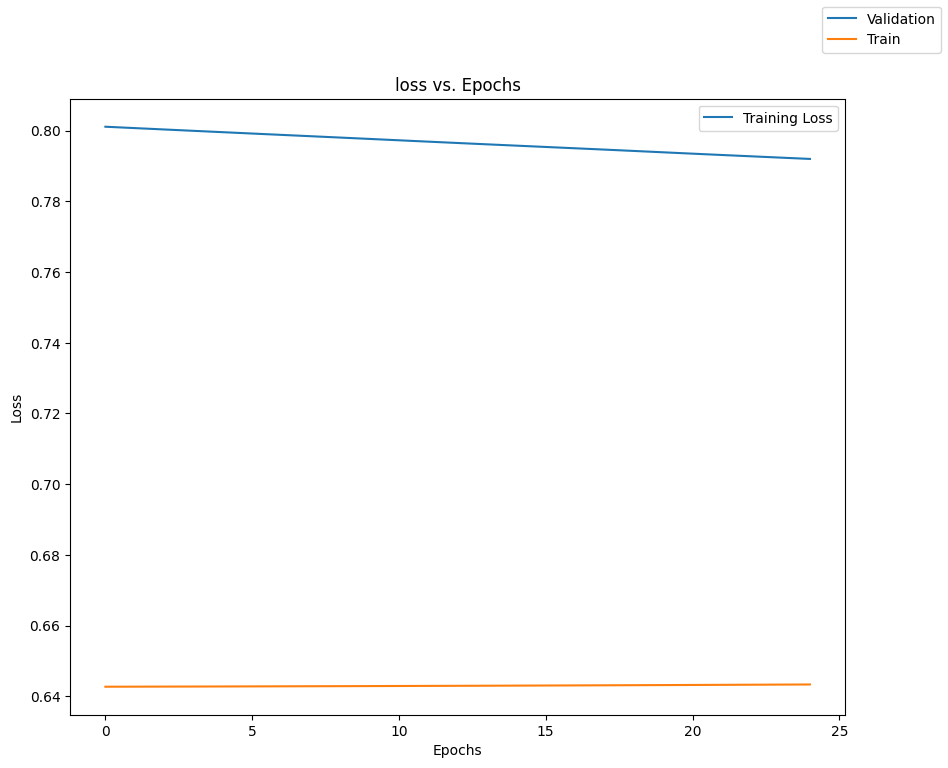

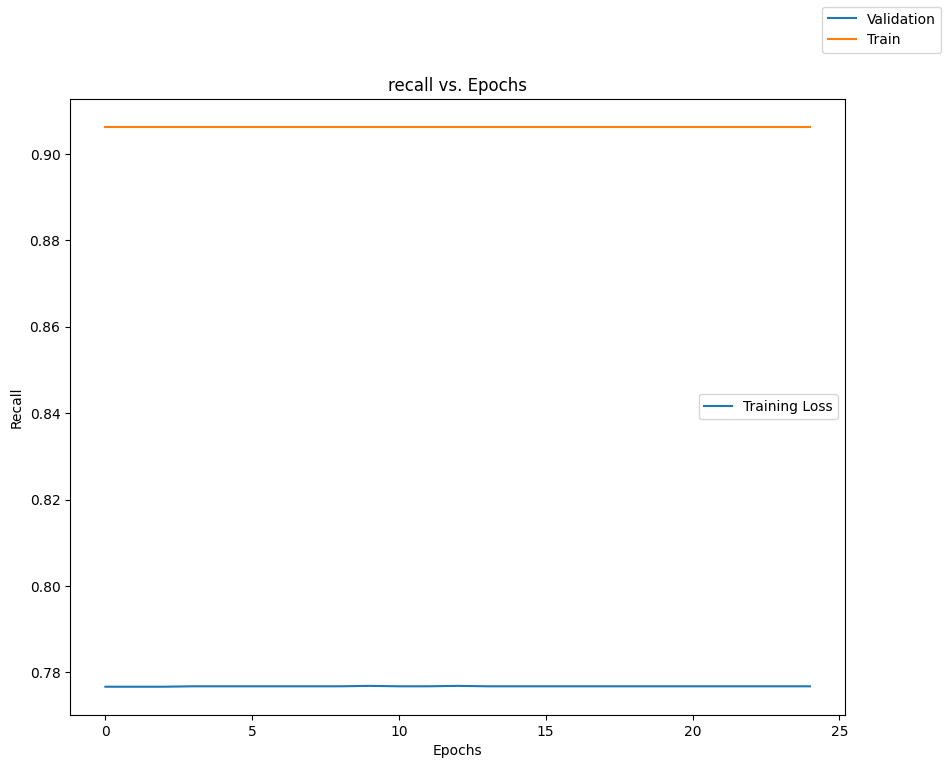

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   
4                   2                     128   
5                   2               [32, 128]   
6                   2                      32   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   
4                         tanh/tanh           25          32   
5                         tanh/tanh           25          32   
6                              tanh           25          32   

               Optimizer Learning Rate Momentum Rate Dropout    Train Loss  \
0               

In [ ]:
#Clear the backend/session history#
K.clear_session()

#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Initialize the model#
model_6 = tf.keras.Sequential()

#Convert target variables#
#Use the variables encoded from applying SMOTE above#

#y_train_over_encoded = tf.keras.utils.to_categorical(y_train_over, num_classes = num_classes)
#y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Add hidden layer as applicable#
model_6.add(tf.keras.layers.Dense(32, activation = 'tanh', input_dim = X_train_over.shape[1]))

#Add hidden layer 2#
model_6.add(tf.keras.layers.Dense(32, activation = 'tanh'))


#Add output layer  as applicable#
model_6.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid') )

#Compile the model using the SGD optimizer#
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0000001)

model_6.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['recall'])


#Specify the batch size and epochs#
batch_size = 32
epochs = 25

#Add the start time#
start = time.time()

#Fit the model#
history = model_6.fit(
    X_train_over, y_train_over_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)

#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')


#Add the results to the dataframe#
results_df.loc[6] = [2, 32, 'tanh', epochs, batch_size, 'Adam', '0.0000001', '-', '-', history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)


To improve the performance above I tried a few different configurations:

Changes to Reduce the Model Complexity:

1. Increasing the batch size to 200 in an attempt to prevent overfitting - Performed worse
2. Keeping the batch size at 32, and reducing the number of epochs to 10
3. Keeping the batch size at 32, and increasing epochs to 50 - Increased overfitting as expected
4. Removing all hidden layers and keeping epochs at 10 - Severe under-fitted, was expected outcome. This validates we likely need a hidden layer to get strong results. Increasing epochs to 30 did not improve- proving the need for the hidden layer.

Changes to Optimize the Model's Complexity:

5. Maintain the existing hidden layer with 32 neurons and tanh activation but increase epochs to 30- this improve performance drastically (val recall at 77.4% but train recall only at 67.2%).
6. Increase epochs to 50 and checked results- no change in recall metrics but closer divergence in losses. --> We are clearly still in the under-fitting region.
7. Increased the number of neurons in the single hidden layer to 64, keep epochs at 50 to obtain the most generalizable performance. This leads training to outperform validation by a substantial margin --> indicating overfitting again
8. Maintain increase in the number of neurons in the single hidden layer at 64, reduce epochs to 30 --> high overfitting again
9. Finally Reduce # of neurons in hidden layers to 32, add a second hidden layer, reduce epochs to 20- This appeared to improve performance remarkably.

### Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.7239 - recall: 0.8926 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7247 - recall: 0.8944 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7247 - recall: 0.8945 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7243 - recall: 0.8952 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7243 - recall: 0.8959 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7243 - recall: 0.8949 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7239 - recall: 0.8963 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7248 - recall: 0.8934 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 9/

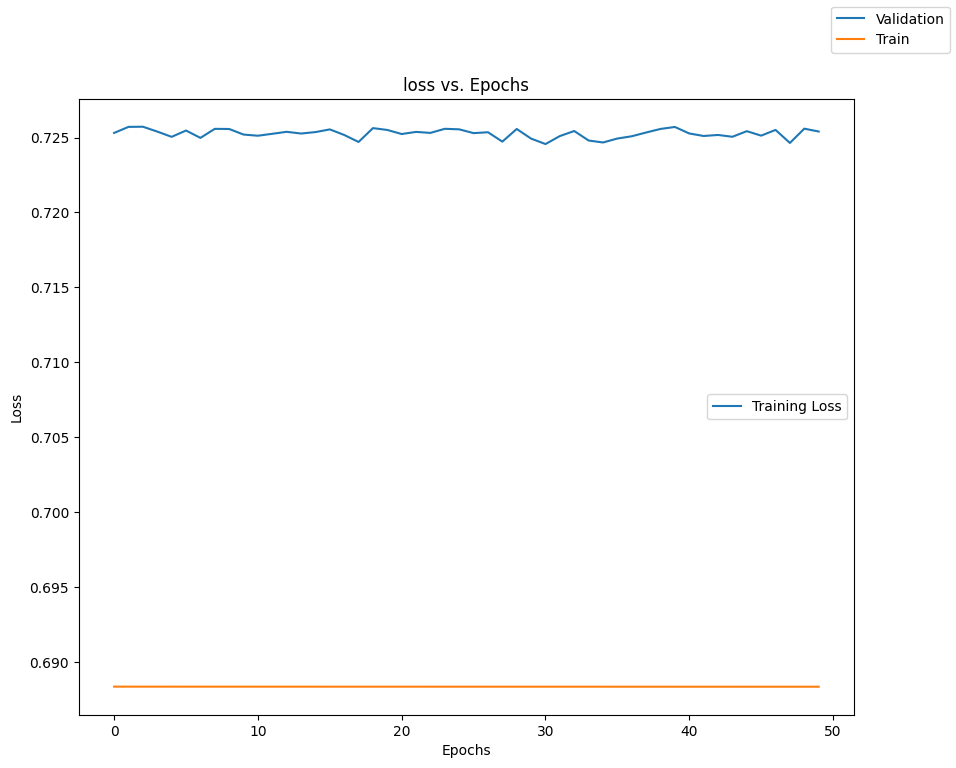

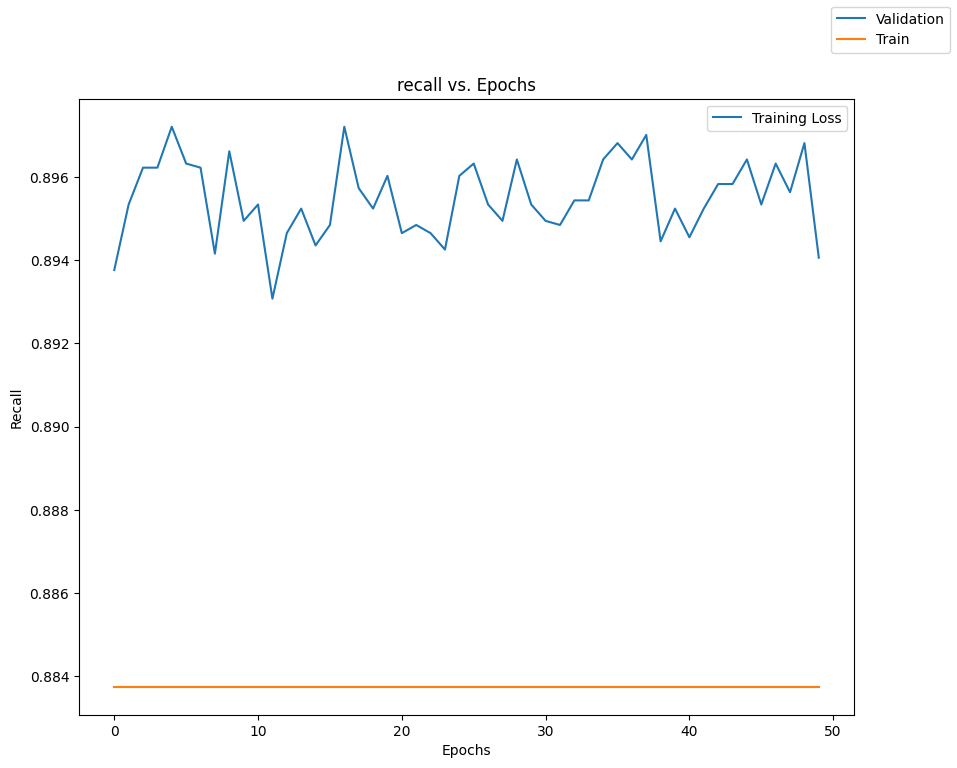

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   
4                   2                     128   
5                   2               [32, 128]   
6                   2                      32   
7                   2                      32   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   
4                         tanh/tanh           25          32   
5                         tanh/tanh           25          32   
6                              tanh           25          32   
7                              tanh           

In [ ]:
#Clear the backend/session history#
K.clear_session()

#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Initialize the model#
model_7 = tf.keras.Sequential()

#Define the drop out rate#
drop_out = 0.01

#Convert target variables#
#Use the variables encoded from applying SMOTE above#

#y_train_over_encoded = tf.keras.utils.to_categorical(y_train_over, num_classes = num_classes)
#y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Add hidden layer as applicable#
model_7.add(tf.keras.layers.Dense(32, activation = 'tanh', input_dim = X_train_over.shape[1]))

#Apply dropout layer#
model_7.add(tf.keras.layers.Dropout(rate = drop_out))

#Add hidden layer 2#
model_7.add(tf.keras.layers.Dense(32, activation = 'tanh'))

#Add output layer  as applicable#
model_7.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid') )

#Compile the model using the SGD optimizer#
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000000001)

model_7.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['recall'])


#Specify the batch size and epochs#
batch_size = 32
epochs = 50

#Add the start time#
start = time.time()

#Fit the model#
history = model_7.fit(
    X_train_over, y_train_over_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)

#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')


#Add the results to the dataframe#
results_df.loc[7] = [2, 32, 'tanh', epochs, batch_size, 'Adam', '0.0000000001', '-', drop_out, history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.7267 - recall: 0.8828 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7276 - recall: 0.8833 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7261 - recall: 0.8797 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7268 - recall: 0.8793 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7262 - recall: 0.8775 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7257 - recall: 0.8773 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7269 - recall: 0.8818 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7259 - recall: 0.8759 - val_loss: 0.6884 - val_recall: 0.8838
Epoch 9/

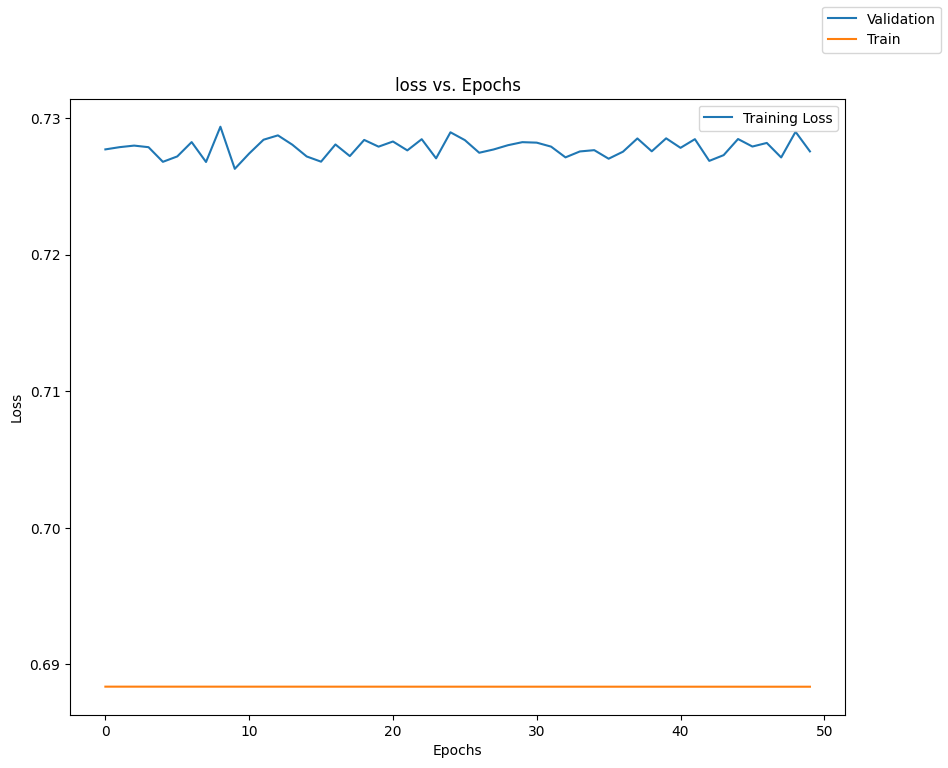

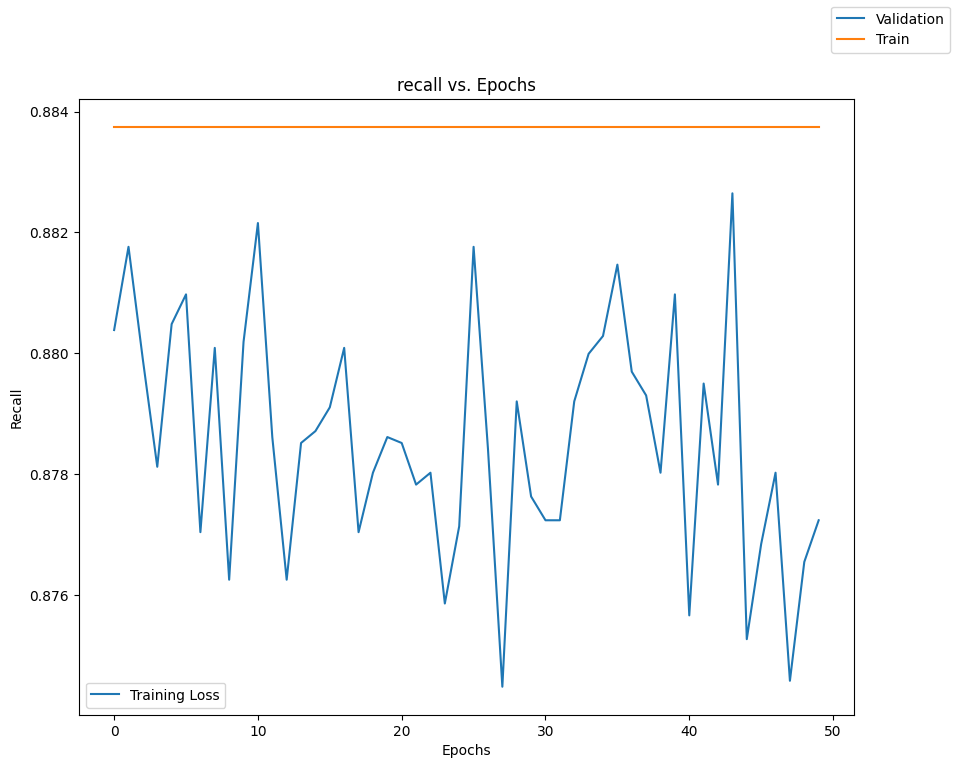

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   
4                   2                     128   
5                   2               [32, 128]   
6                   2                      32   
7                   2                      32   
8                   2                      32   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   
4                         tanh/tanh           25          32   
5                         tanh/tanh           25          32   
6                              tanh           25          32 

In [ ]:
#Clear the backend/session history#
K.clear_session()

#Set the random seed prior to modeling#
tf.keras.utils.set_random_seed(418)

#Initialize the model#
model_8 = tf.keras.Sequential()

#Define the drop out rate#
drop_out = 0.05

#Convert target variables#
#Use the variables encoded from applying SMOTE above#

#y_train_over_encoded = tf.keras.utils.to_categorical(y_train_over, num_classes = num_classes)
#y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes = num_classes)

#Add hidden layer as applicable#
model_8.add(tf.keras.layers.Dense(32, activation = 'tanh', input_dim = X_train_over.shape[1]))

#Apply dropout layer#
model_8.add(tf.keras.layers.Dropout(rate = drop_out))

#Add hidden layer 2#
model_8.add(tf.keras.layers.Dense(32, activation = 'tanh'))


#Add output layer  as applicable#
model_8.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid') )

#Compile the model using the SGD optimizer#
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000000001)

model_8.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['recall'])


#Specify the batch size and epochs#
batch_size = 32
epochs = 50

#Add the start time#
start = time.time()

#Fit the model#
history = model_8.fit(
    X_train_over, y_train_over_encoded,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val_encoded)
)

#Add the end time#
end = time.time()

#Plot the history#
plot(history, 'loss')
plot(history, 'recall')


#Add the results to the dataframe#
results_df.loc[8] = [2, 32, 'tanh/tanh', epochs, batch_size, 'Adam', '0.0000000001', '-', drop_out, history.history['loss'][-1], history.history['val_loss'][-1], history.history['recall'][-1], history.history['val_recall'][-1], end - start]

print(results_df)

## Model Performance Comparison and Final Model Selection

The final neural network model gave the highest validation recall score, and the smallest gap between train and validation recall. However, this neural network also gave a slightly higher loss than some of the earlier variants.

However, our metric of success is recall and thus we will go with the final neural network model we built. The loss is marginally higher compared to earlier alternatives but significantly lower than the first 2 baseline models we built, and has much better reliability on predicting the factors that are likely to lead to churning customers.

   # of Hidden Layers # neurons- Hidden Layer  \
0                   0                       -   
1                   0                       -   
2                   2                     128   
3                   2                     128   
4                   2                     128   
5                   2               [32, 128]   
6                   2                      32   
7                   2                      32   
8                   2                      32   

  activation function- hidden layer  # of epochs  batch_size  \
0                                 -           10        6400   
1                                 -           25          32   
2                         relu/tanh           25          32   
3                         tanh/tanh           25          32   
4                         tanh/tanh           25          32   
5                         tanh/tanh           25          32   
6                              tanh           25          32 

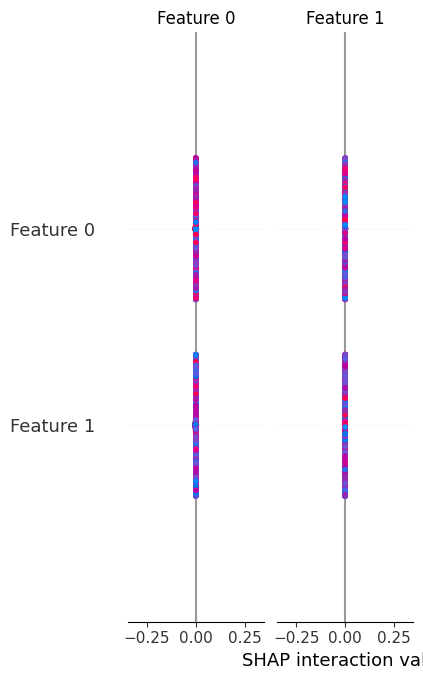

In [ ]:
#Compute SHAP Values on the final model#

print(results_df)

final_model = model_8

#Convert to numpy array#
X_train_over_vals = X_train_over.values


#SHAP Values#
explainer = shap.DeepExplainer(model_8, X_train_over_vals)

shap_values = explainer.shap_values(X_train_over_vals)


#shap_values = explainer.shap_values(X_train_scaled)

# Summary plot for a global representation of feature importance
#shap.summary_plot(shap_values, X_train_over_vals)



I honestly found the shap values very difficult to understand and discern without a simpler baseline apporach.
So as a baseline I will implement logistic regression to find the probabilities associated with each class and then analyze the feature importances.

LogisticRegression(random_state=418)
              Feature  Coefficient
2              Tenure     0.146800
6      IsActiveMember     0.101140
10        Gender_Male     0.085560
4       NumOfProducts     0.070785
1                 Age    -0.070754
5           HasCrCard     0.045549
9     Geography_Spain     0.042043
8   Geography_Germany    -0.004611
0         CreditScore     0.003280
3             Balance    -0.000004
7     EstimatedSalary     0.000000


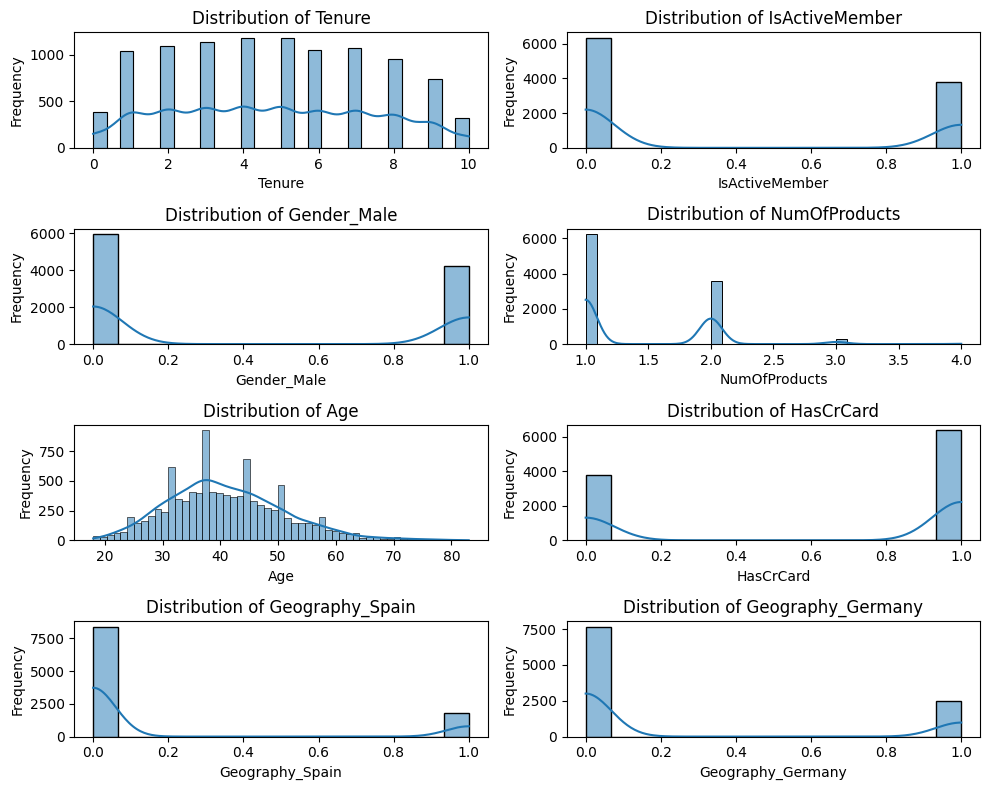

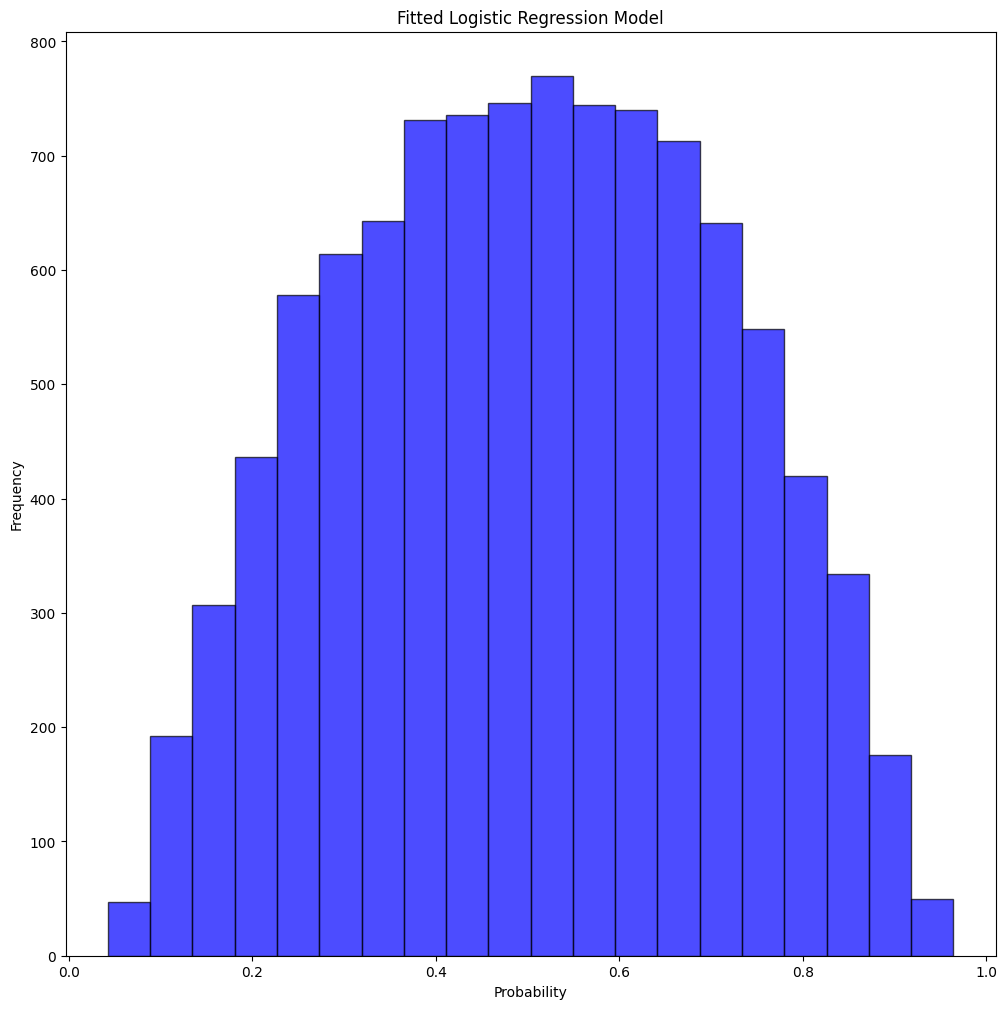

'\n#Dive further into this by plotting the percentage distribution of each bin#\nprob_bins = np.linspace(0, 1, 20)  # 20 bins between 0 and 1\n\nhist, bins = np.histogram(probs, bins=prob_bins, density=False)\npercentages = hist / len(probs) * 100\n\nplt.bar(bins[:-1], percentages, width=np.diff(bins), align="edge", edgecolor=\'black\')\nplt.title(\'Percentage of Population in Probability Buckets\')\nplt.xlabel(\'Predicted Probability\')\nplt.ylabel(\'Percentage of Observations\')\nplt.xticks(np.arange(0, 1.1, step=0.1))\nplt.grid(visible=True, linestyle=\'--\', alpha=0.7)\nplt.show()\n\n#Create a plot of the CDF#\n\n#First calculate the mean value#\n#mean = X_train_over.mean()\n#std_dev = X_train_over.std()\n\n#cdf = stats.norm.cdf(X_train_over, loc=mean, scale = std_dev)#\n\n\n# Suppose `feature` is the column you\'re interested in\n\n\nfor column in X_train_over.columns:\n    feature_data = X_train_over[column]\n\n    # Calculate the empirical CDF values\n    # Sort the feature data

In [ ]:

pd.set_option('display.float_format', '{:.6f}'.format)


#Implement LogisticRegression#
#Instantiate the model#
log_model = LogisticRegression(random_state = 418)
print(log_model)

#Fit the model#
fitted_log_model = log_model.fit(X_train_over, y_train_over)

##Predict Probabilities##
#First predict the label#
y_predict_train = fitted_log_model.predict(X_train_over)
#Then predict the probabilities#
y_predict_proba_train = fitted_log_model.predict_proba(X_train_over)


##Store probabilities in a matrix##
probs = fitted_log_model.predict_proba(X_train_over)[:, 1]


##Extract Feature Importances##
# Coefficients of the model
coefficients = fitted_log_model.coef_[0]  # As this returns an array of arrays

# Create a DataFrame displaying feature names and corresponding coefficients
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    #Convert from odds ratios to probability values by exponentiating and then subtracting the results from 1#
    'Coefficient': 1-(np.exp(coefficients))
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Display feature importances
print(feature_importances)

#Isolate the most important features and investigate further#
important_features = ['Tenure', 'IsActiveMember', 'Gender_Male', 'NumOfProducts', 'Age', 'HasCrCard', 'Geography_Spain', 'Geography_Germany']

plt.figure(figsize=(10, 8))

for idx, feature in enumerate(important_features, 1):
    plt.subplot(4, 2, idx)  # Adjust layout as needed
    sns.histplot(X_train_over[feature], kde=True)  # Plot histogram and KDE
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#Create a histogram to plot the logisitic output and see whether the probabilities appear to be normally distributed or not#

plt.figure(figsize=(12, 12))
plt.title('Fitted Logistic Regression Model')
plt.hist(probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()







*   Most customers have a tenure of around 1-9 years with the bank

*   About 60% of the bank's customers are Female with the remainder being male.

*   We observed in our feature importances that this appears to be an important factor in predicting churn.


*   ~60% of the customers have one financial product with the bank, 30% have 2, and only 10% have 3 or more. We observed in our feature importantance that the greater the num of financial products a customer has with the bank, the lower their odds of churning.


*   The average customer appears to be in their 30s/40s with a large right tail of customers who are over 60

*   ~40% of bank customers have a credit card with the bank.


*   ~35% of the bank's customers are an active member and thus are less likely to churn



We now will want to dig deeper into these features to understand the full statistical/probability distributions of each importance

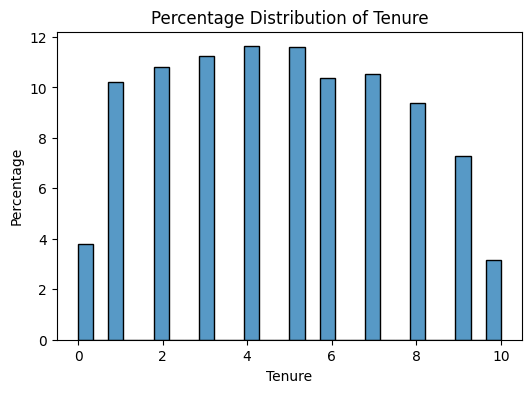

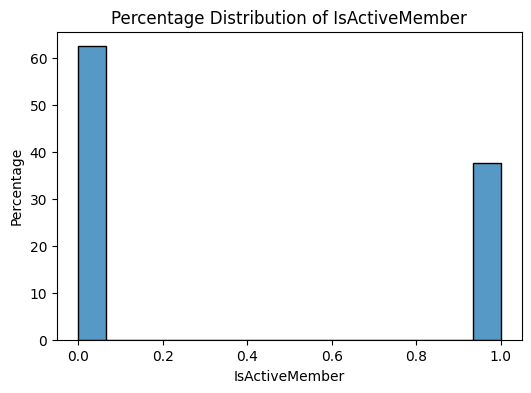

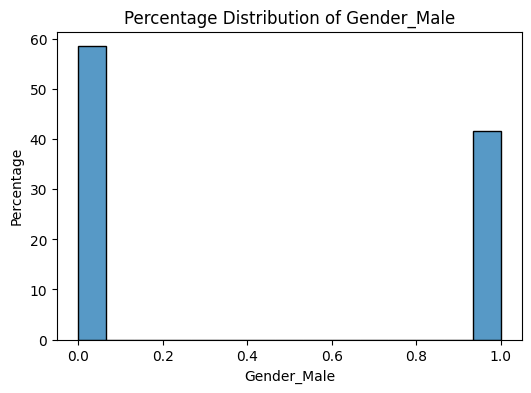

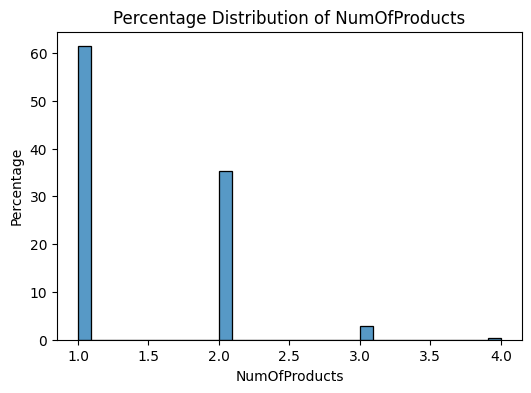

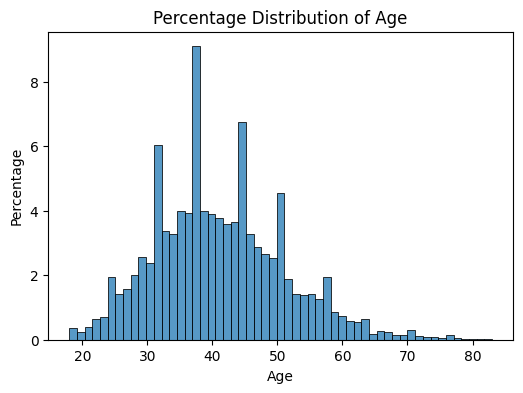

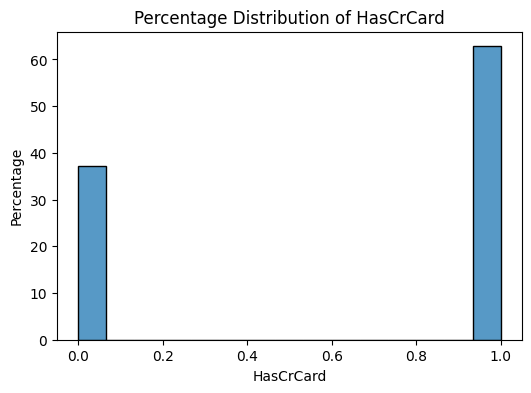

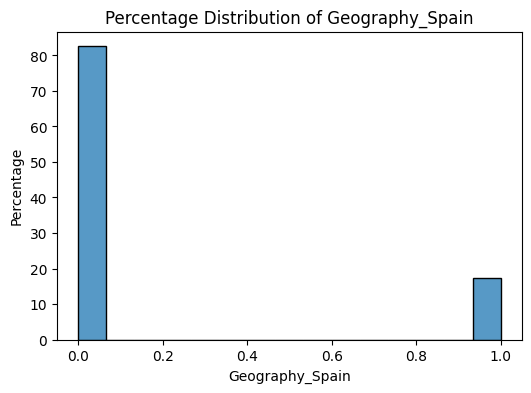

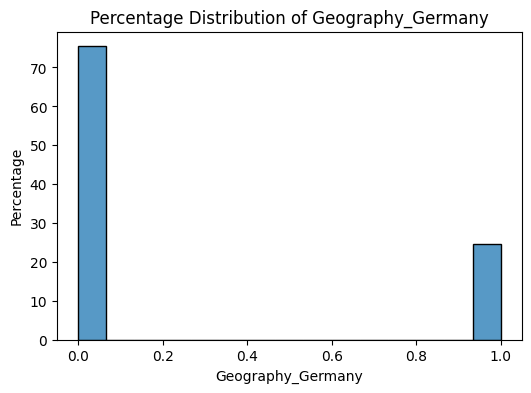

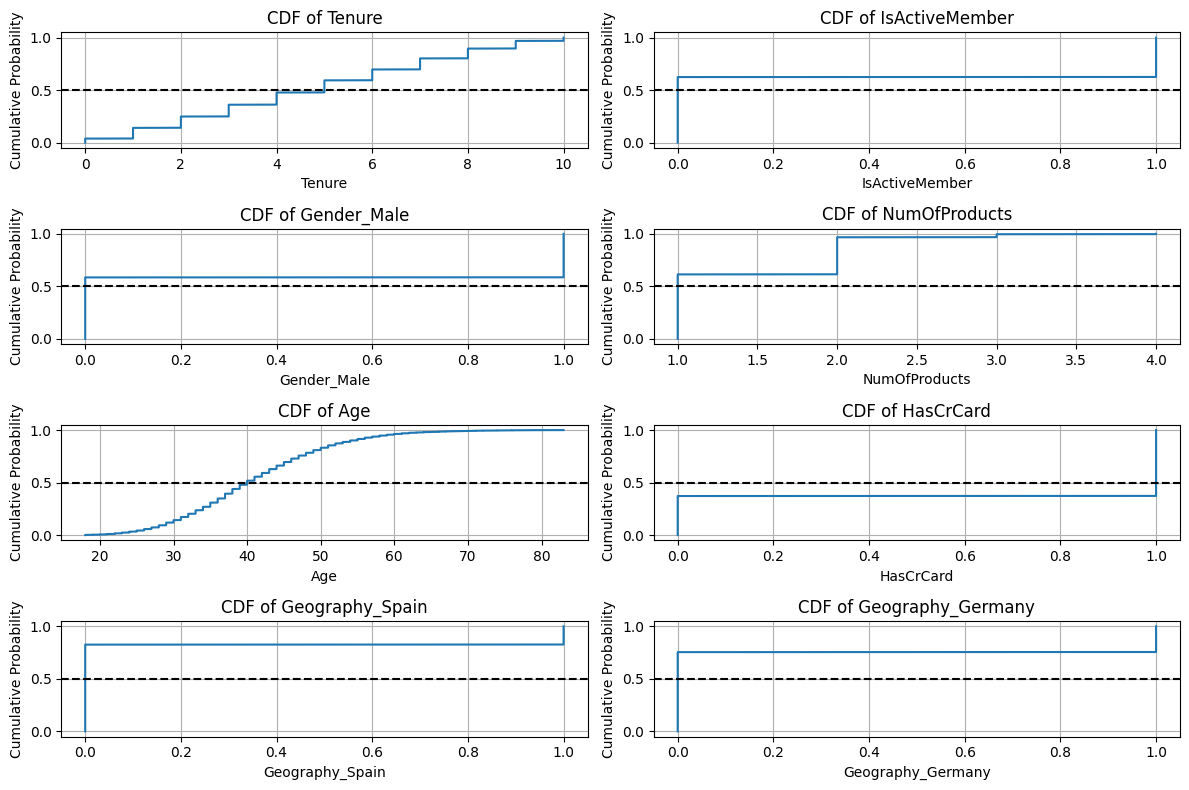

In [ ]:

#Isolate the most important features and investigate further#

important_features = ['Tenure', 'IsActiveMember', 'Gender_Male', 'NumOfProducts', 'Age', 'HasCrCard', 'Geography_Spain', 'Geography_Germany']

#plt.figure(figsize=(10, 8))

for idx, feature in enumerate(important_features, 1):

# Plotting the percentage distribution of the key features#
  plt.figure(figsize=(6, 4))
  sns.histplot(X_train_over[feature], stat='percent', kde=False)  # Set stat to 'percent' to show percentages
  plt.title('Percentage Distribution of ' + feature)
  plt.xlabel(feature)
  plt.ylabel('Percentage')
  plt.show()


#Validate insights/conclusions by plotting the CDF#

# Create subplots for CDFs
n_features = len(important_features)
n_cols = 2
n_rows = (n_features + 1) // n_cols

#Setup the figure and axes#
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()  # Convert subplot axes to a 1D array for iteration

#Loop through each feature in the training set#
for idx, feature in enumerate(important_features):
    if feature in X_train_over.columns:
        # Compute the CDF
        #To compute the CDF we need to sort the values based upon density#
        sorted_values = np.sort(X_train_over[feature])
        yvals = np.arange(1, len(sorted_values) + 1) / len(sorted_values)

        # Plot CDF for each feature on the subplots#
        axes[idx].plot(sorted_values, yvals)
        axes[idx].set_title(f'CDF of {feature}')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Cumulative Probability')
        axes[idx].grid(True)

        #Add a dividing line for visual appeal#
        axes[idx].axhline(y = 0.5, linestyle='--', color='black')

# Remove any empty subplots
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()






In a real-world scenario we would want to confirm these approximate logistic regression results using a more advanced model, before we draw any concrete conclusions or put the neural network into production.

However, the plots above I believe give us enough evidence to start coming to some clear conclusions with respect to the key drivers of churn and enough evidence to push this model into production after a test validation.



## Actionable Insights and Business Recommendations


-The bank has a strong concentration of customers who have been tenured with the bank for more than 2 years but less than 6 years. Based upon the feature importances, tenure with the bank tends to reduce the risk of churning by ~15%.
The bank should concentrate on these groups of customers and ensure they do not churn from the bank. The business should offer incentives to customers who have a particularly high probability of churning to stay with the bank.

-The bank also needs to reward their long-time members with targeted promotions to further increase their stickiness, with particular attention (to the degree allowable by law) to its female customers.

-The bank should offer incentives and promotions to customers who are not a member of the bank to become one. Being an active member of the bank decreases churn probability by 10%. An effective cross-promotion would be to entice customers to sign up with the bank with substantial incentives, they can further hook the customer by offering an opportunity to sign up for another financial product if they only have 1, and especially if that product is maturing soon. Customers with a larger number of financial products have a 7% decrease churn probability.

-To the degree possible, The bank should encourage branch employees to upsell customers to different financial products than just a credit card. Having a credit card reduces churn probability by 4%, wheras having a different financial product with the bank (such as a savings account) would increase the probability by 7%.





<font size=6 color='blue'>Power Ahead</font>
___